# Data and Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

In [3]:
aug_speeds = {"keyboard": 117, "char_substitute": 109, "char_insert": 109, "char_swap": 114,
              "ocr": 114, "char_delete": 108,
              "word_insert": 0.0, "word_substitute": 0.0, "text_rotate": 32,
              "stopword_insert": 34, "word_join": 32, "word_cutout": 36,
              "w2v_insert": 0.0, "w2v_substitute": 0.0, 
              "fasttext": 137, "glove_twitter": 88, "glove_wiki": 82, "word2vec": 137,
              "synonym": 522, "split": 110, "sentence_shuffle": 67, "one_third_cut": 0.0, "half_cut":0.0}


- What Augs are useful
- What Text models perform best

In [4]:


choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.3, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.5, "sentence_shuffle": 0.5, "one_third_cut": 0.3, "half_cut":0.1}
preprocess_text = TextAugment([0.05, 0.05, 0.05, 0.35, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, 
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# images = list(data["train"].img) + list(data["test"].img)
# pd.DataFrame({"img":images}).to_csv("image.csv", header=None, index=None)

# ImageAugment([0.2, 0.5, 0.3])


## Sampling

In [5]:
df = data["train"]
df.label.value_counts()
ones = df[df["label"]==1].sample(2400)
df = pd.concat((df, ones))
df.label.value_counts()
data["train"] = df

0    5700
1    3300
Name: label, dtype: int64

1    5700
0    5700
Name: label, dtype: int64

In [5]:
df = data["train"]
df.label.value_counts()
ones = df[df["label"]==1].sample(500)
df = pd.concat((df, ones))
df.label.value_counts()
data["train"] = df

# 60-40

0    5700
1    3300
Name: label, dtype: int64

0    5700
1    3800
Name: label, dtype: int64

In [6]:
df = data["train"]
df.label.value_counts()
ones = df[df["label"]==1].sample(5250, replace=True)
df = pd.concat((df, ones))
df.label.value_counts()
data["train"] = df

# 40-60

0    5700
1    3300
Name: label, dtype: int64

1    8550
0    5700
Name: label, dtype: int64

In [5]:
df = data["train"]
df.label.value_counts()
zeros = df[df["label"]==0].sample(3000)
df = pd.concat((df, zeros))
df.label.value_counts()
data["train"] = df

0    5700
1    3300
Name: label, dtype: int64

0    8700
1    3300
Name: label, dtype: int64

https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Params

In [5]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




In [6]:
batch_size=256
epochs = 10
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()



In [7]:
from facebook_hateful_memes_detector.utils import in_notebook, CNNHead, MultiLayerTransformerDecoderHead, AveragedLinearHead, OneTokenPositionLinearHead, MultiTaskForward, CNN2DHead
def fb_detr_loss_builder(n_dims, n_tokens, n_out, dropout, loss="classification"):
    loss = "classification" if loss is None else loss
    cnn = MultiLayerTransformerDecoderHead(n_dims, n_tokens, n_out, dropout, 
                                           gaussian_noise=0.0, loss=loss, n_layers=3)
    mtf = MultiTaskForward([cnn])
    return mtf

# Fasttext 1D CNN

## 512 DIMS

In [ ]:
epochs = 15
model_fn = model_builder(Fasttext1DCNNModel, 
                         dict(classifier_dims=256, num_classes=2, 
                              n_layers=2, final_layer_builder=fb_1d_loss_builder,
                              gaussian_noise=0.15, dropout=0.2, embedding_dims=256, internal_dims=512,
                             fasttext_file="crawl-300d-2M-subword.bin", featurizer="transformer",),
                         optimiser_class=optimizer, optimiser_params=optimizer_params)





multi_eval=False 
kfold=False
results, prfs = train_validate_ntimes(model_fn, data, batch_size, epochs, 
                                      augmentation_weights=augmentation_weights, 
                                      kfold=kfold, multi_eval=multi_eval,
                                      scheduler_init_fn=scheduler_init_fn, 
                                      validation_epochs=[4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs

# 0.738	0.734
# 0.730	0.715
# 0.730	0.715
# 0.734	0.731
# 0.746	0.712


# Lang Features Model

In [ ]:
epochs = 15
batch_size=256
# fasttext_crawl 1.9s
# spacy 1.8s
# full_view 1.4s 0.659	0.651
# gensim 7.5s # 0.718	0.737
# nltk 3s 0.609	0.585
# "spacy", "key_phrases" 4.2s 0.688	0.670
# "fasttext_crawl", "spacy", "key_phrases", "gensim" 20s 0.763	0.729 2h 49m
# "fasttext_crawl", "gensim" 11s 0.749	0.733 1h 47m
# gensim 8s 0.751	0.733 1h 20m

all_caps = ["fasttext_crawl", "spacy", "full_view", "key_phrases", "nltk", "gensim"] # "snlp", "ibm_max", "tmoji", "key_phrases", "full_view", "spacy", "nltk", "fasttext_crawl"
all_caps = ["full_view",]
all_caps = ["fasttext_crawl", "spacy", "key_phrases", "nltk"]
all_caps = ["fasttext_crawl", "gensim"]
model_fn = model_builder(LangFeaturesModel, 
                         dict(classifier_dims=256, num_classes=2, 
                              gaussian_noise=0.2, dropout=0.2, embedding_dims=256, internal_dims=512,
                              capabilities=all_caps, featurizer="transformer", n_layers=2, 
                              final_layer_builder=fb_1d_loss_builder),
                         optimiser_class=optimizer, optimiser_params=optimizer_params)



multi_eval=False
kfold=False
results, prfs = train_validate_ntimes(model_fn, data, batch_size, epochs, 
                                      augmentation_weights=augmentation_weights, 
                                      kfold=kfold, multi_eval=multi_eval,
                                      scheduler_init_fn=scheduler_init_fn, 
                                      validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs


# BERT Models

## Not FineTuned

### DistilRoberta

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.410271 LR = 0.00000007



Epoch =  2 Loss = 0.389502 LR = 0.00000014



Epoch =  3 Loss = 0.372000 LR = 0.00000021



Epoch =  4 Loss = 0.350737 LR = 0.00000028
Epoch =  4 Train = 0.607691 Val = 0.615326



Epoch =  5 Loss = 0.313252 LR = 0.00000035


Exception for:  keyboard | ' ' ' ' | ['sentence_shuffle' 'half_cut' 'text_rotate' 'char_delete' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  6 Loss = 0.296716 LR = 0.00000042



Epoch =  7 Loss = 0.276376 LR = 0.00000049
Epoch =  7 Train = 0.612593 Val = 0.616175



Epoch =  8 Loss = 0.267245 LR = 0.00000056



Epoch =  9 Loss = 0.259670 LR = 0.00000062
Epoch =  9 Train = 0.609287 Val = 0.613518



Epoch =  10 Loss = 0.233012 LR = 0.00000069



Epoch =  11 Loss = 0.245536 LR = 0.00000076
Epoch =  11 Train = 0.608035 Val = 0.611702



Epoch =  12 Loss = 0.244397 LR = 0.00000083


Exception for:  keyboard | '' '' | ['half_cut' 'sentence_shuffle' 'keyboard' 'text_rotate'] argument of type 'NoneType' is not iterable

Epoch =  13 Loss = 0.216572 LR = 0.00000090



Epoch =  14 Loss = 0.225468 LR = 0.00000097
Epoch =  14 Train = 0.633190 Val = 0.635811



Epoch =  15 Loss = 0.215615 LR = 0.00000100



Epoch =  16 Loss = 0.212920 LR = 0.00000099



Epoch =  17 Loss = 0.213031 LR = 0.00000099
Epoch =  17 Train = 0.705890 Val = 0.704537



Epoch =  18 Loss = 0.213721 LR = 0.00000097



Epoch =  19 Loss = 0.204635 LR = 0.00000095
Epoch =  19 Train = 0.705098 Val = 0.706297



Epoch =  20 Loss = 0.190522 LR = 0.00000093



Epoch =  21 Loss = 0.187127 LR = 0.00000091



Epoch =  22 Loss = 0.176494 LR = 0.00000088



Epoch =  23 Loss = 0.176353 LR = 0.00000085
Epoch =  23 Train = 0.728983 Val = 0.732846



Epoch =  24 Loss = 0.164269 LR = 0.00000081



Epoch =  25 Loss = 0.165019 LR = 0.00000077



Epoch =  26 Loss = 0.158516 LR = 0.00000073



Epoch =  27 Loss = 0.151574 LR = 0.00000069
Epoch =  27 Train = 0.736978 Val = 0.736019



Epoch =  28 Loss = 0.162375 LR = 0.00000065



Epoch =  29 Loss = 0.149672 LR = 0.00000060



Epoch =  30 Loss = 0.153491 LR = 0.00000056



Epoch =  31 Loss = 0.145834 LR = 0.00000051
Epoch =  31 Train = 0.744044 Val = 0.741482



Epoch =  32 Loss = 0.142110 LR = 0.00000046



Epoch =  33 Loss = 0.145462 LR = 0.00000042



Epoch =  34 Loss = 0.134812 LR = 0.00000037
Epoch =  34 Train = 0.751897 Val = 0.746101



Epoch =  35 Loss = 0.139353 LR = 0.00000033



Epoch =  36 Loss = 0.133833 LR = 0.00000028



Epoch =  37 Loss = 0.132148 LR = 0.00000024
Epoch =  37 Train = 0.754861 Val = 0.747017



Epoch =  38 Loss = 0.129405 LR = 0.00000020



Epoch =  39 Loss = 0.127689 LR = 0.00000017



Epoch =  40 Loss = 0.127912 LR = 0.00000013



Epoch =  41 Loss = 0.125368 LR = 0.00000010
Epoch =  41 Train = 0.759277 Val = 0.750005



Epoch =  42 Loss = 0.123843 LR = 0.00000008



Epoch =  43 Loss = 0.126183 LR = 0.00000005



Epoch =  44 Loss = 0.125468 LR = 0.00000003
Epoch =  44 Train = 0.759942 Val = 0.750313



Epoch =  45 Loss = 0.121675 LR = 0.00000002



Epoch =  46 Loss = 0.124090 LR = 0.00000001



Epoch =  47 Loss = 0.121253 LR = 0.00000000
Epoch =  47 Train = 0.759849 Val = 0.750153



Epoch =  48 Loss = 0.122507 LR = 0.00000000



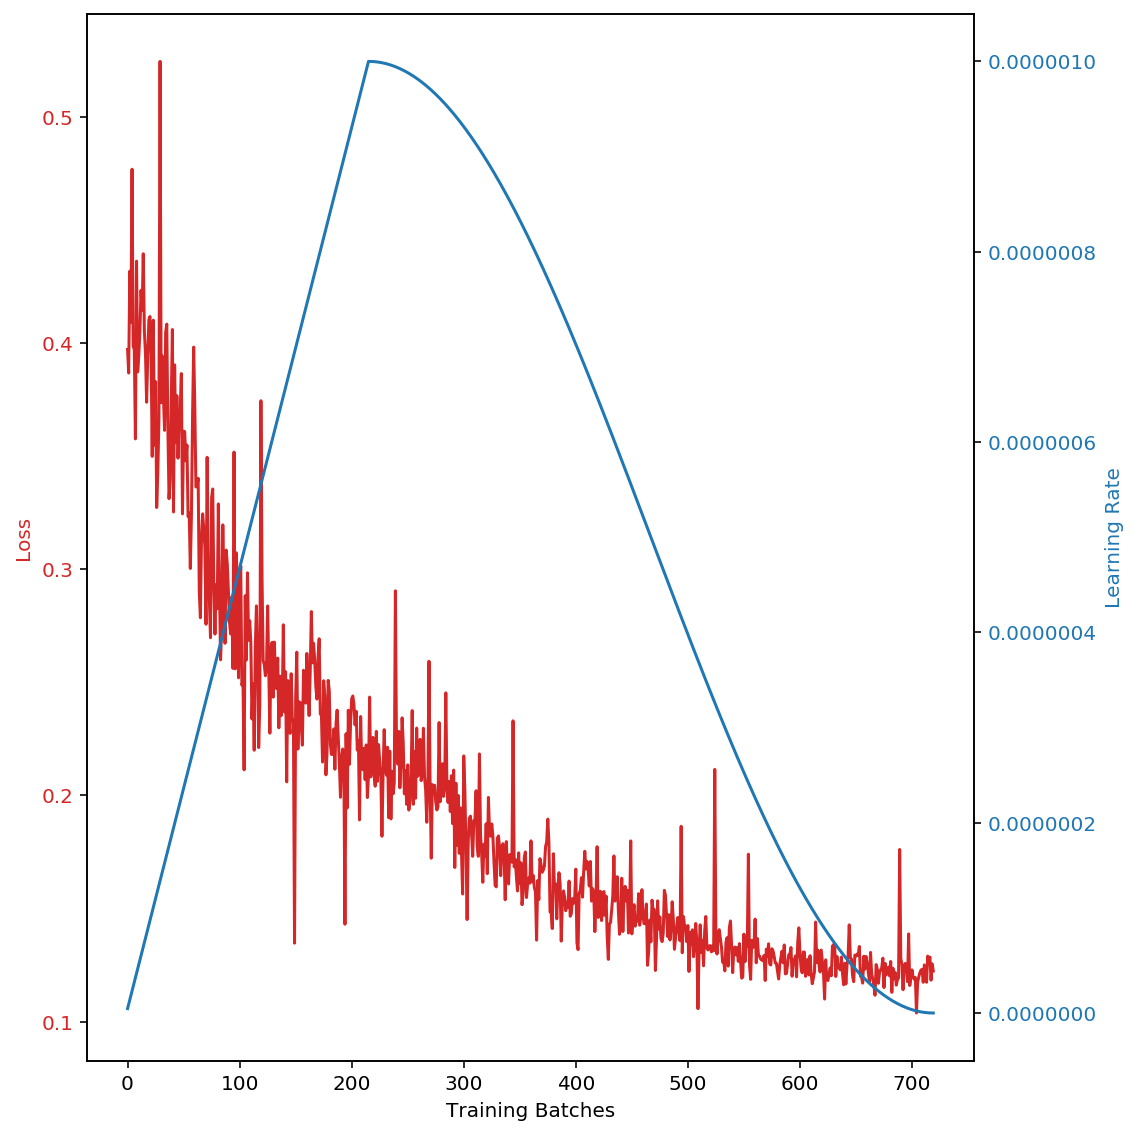

train   val
mean_or_std metric               
mean        map       0.668 0.634
            accuracy  0.724 0.707
            auc       0.760 0.750
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.720  0.922 0.809 4560.000     0.708  0.917 0.799 1140.000
pos     0.740  0.381 0.503 2640.000     0.706  0.345 0.464  660.000

In [8]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=4.5,
                              dropout=0.15,
                              word_masking_proba=0.0,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilroberta-base',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.759	0.752 (0.717	0.716)

# 0.0.760	0.745 (725	0.721) # 15m 41s


In [ ]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=5.0, # 4.75 0.764	0.726
                              dropout=0.175,
                              word_masking_proba=0.225,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilroberta-base',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.759	0.752 (0.717	0.716)

# 0.0.760	0.745 (725	0.721) # 15m 41s


### DETR style Transformer layer

In [ ]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=4.0,
                              dropout=0.125,
                              word_masking_proba=0.175,
                              internal_dims=512,
                              final_layer_builder=fb_detr_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=32,
                              featurizer="transformer",
                              model='distilroberta-base',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.759	0.752 (0.717	0.716)
# 0.0.760	0.745 (725	0.721) # 15m 41s


Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.206217 LR = 0.00000007



Epoch =  2 Loss = 0.163442 LR = 0.00000014



Epoch =  3 Loss = 0.150179 LR = 0.00000021



Epoch =  4 Loss = 0.137465 LR = 0.00000028
Epoch =  4 Train = 0.591716 Val = 0.569203



Epoch =  5 Loss = 0.130829 LR = 0.00000035



Epoch =  6 Loss = 0.125634 LR = 0.00000042



Epoch =  7 Loss = 0.117684 LR = 0.00000049
Epoch =  7 Train = 0.596882 Val = 0.576524



Epoch =  8 Loss = 0.112546 LR = 0.00000056



Epoch =  9 Loss = 0.108316 LR = 0.00000062


Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.214924 LR = 0.00000007



Epoch =  2 Loss = 0.185491 LR = 0.00000014



Epoch =  3 Loss = 0.173010 LR = 0.00000021



Epoch =  4 Loss = 0.163965 LR = 0.00000028
Epoch =  4 Train = 0.612732 Val = 0.611594



Epoch =  5 Loss = 0.156083 LR = 0.00000035



Epoch =  6 Loss = 0.155207 LR = 0.00000042



Epoch =  7 Loss = 0.150835 LR = 0.00000049
Epoch =  7 Train = 0.624872 Val = 0.626676



Epoch =  8 Loss = 0.138526 LR = 0.00000056



Epoch =  9 Loss = 0.127843 LR = 0.00000062
Epoch =  9 Train = 0.663029 Val = 0.669322



Epoch =  10 Loss = 0.123874 LR = 0.00000069



Epoch =  11 Loss = 0.116333 LR = 0.00000076
Epoch =  11 Train = 0.702030 Val = 0.712840



Epoch =  12 Loss = 0.113655 LR = 0.00000083



Epoch =  13 Loss = 0.113238 LR = 0.00000090



Epoch =  14 Loss = 0.109479 LR = 0.00000097
Epoch =  14 Train = 0.711632 Val = 0.718645



Epoch =  15 Loss = 0.108781 LR = 0.00000100



Epoch =  16 Loss = 0.106486 LR = 0.00000099



Epoch =  17 Loss = 0.104175 LR = 0.00000099
Epoch =  17 Train = 0.728165 Val = 0.730406



Epoch =  18 Loss = 0.103162 LR = 0.00000097



Epoch =  19 Loss = 0.103123 LR = 0.00000095
Epoch =  19 Train = 0.732137 Val = 0.731981



Epoch =  20 Loss = 0.102604 LR = 0.00000093



Epoch =  21 Loss = 0.101937 LR = 0.00000091



Epoch =  22 Loss = 0.100819 LR = 0.00000088



Epoch =  23 Loss = 0.101234 LR = 0.00000085
Epoch =  23 Train = 0.741842 Val = 0.740675



Epoch =  24 Loss = 0.101923 LR = 0.00000081



Epoch =  25 Loss = 0.102351 LR = 0.00000077



Epoch =  26 Loss = 0.100622 LR = 0.00000073



Epoch =  27 Loss = 0.099389 LR = 0.00000069
Epoch =  27 Train = 0.751282 Val = 0.744899



Epoch =  28 Loss = 0.098882 LR = 0.00000065



Epoch =  29 Loss = 0.098947 LR = 0.00000060



Epoch =  30 Loss = 0.098356 LR = 0.00000056



Epoch =  31 Loss = 0.098684 LR = 0.00000051
Epoch =  31 Train = 0.753277 Val = 0.748034



Epoch =  32 Loss = 0.098391 LR = 0.00000046



Epoch =  33 Loss = 0.098460 LR = 0.00000042



Epoch =  34 Loss = 0.097893 LR = 0.00000037
Epoch =  34 Train = 0.753878 Val = 0.746576



Epoch =  35 Loss = 0.097957 LR = 0.00000033



Epoch =  36 Loss = 0.097474 LR = 0.00000028



Epoch =  37 Loss = 0.097199 LR = 0.00000024
Epoch =  37 Train = 0.755695 Val = 0.748545



Epoch =  38 Loss = 0.097256 LR = 0.00000020



Epoch =  39 Loss = 0.096951 LR = 0.00000017



Epoch =  40 Loss = 0.096940 LR = 0.00000013



Epoch =  41 Loss = 0.096778 LR = 0.00000010
Epoch =  41 Train = 0.756127 Val = 0.748904



Epoch =  42 Loss = 0.096598 LR = 0.00000008



Epoch =  43 Loss = 0.096541 LR = 0.00000005



Epoch =  44 Loss = 0.096565 LR = 0.00000003
Epoch =  44 Train = 0.756261 Val = 0.747196



Epoch =  45 Loss = 0.096387 LR = 0.00000002



Epoch =  46 Loss = 0.096218 LR = 0.00000001



Epoch =  47 Loss = 0.096355 LR = 0.00000000
Epoch =  47 Train = 0.756808 Val = 0.747495



Epoch =  48 Loss = 0.096393 LR = 0.00000000



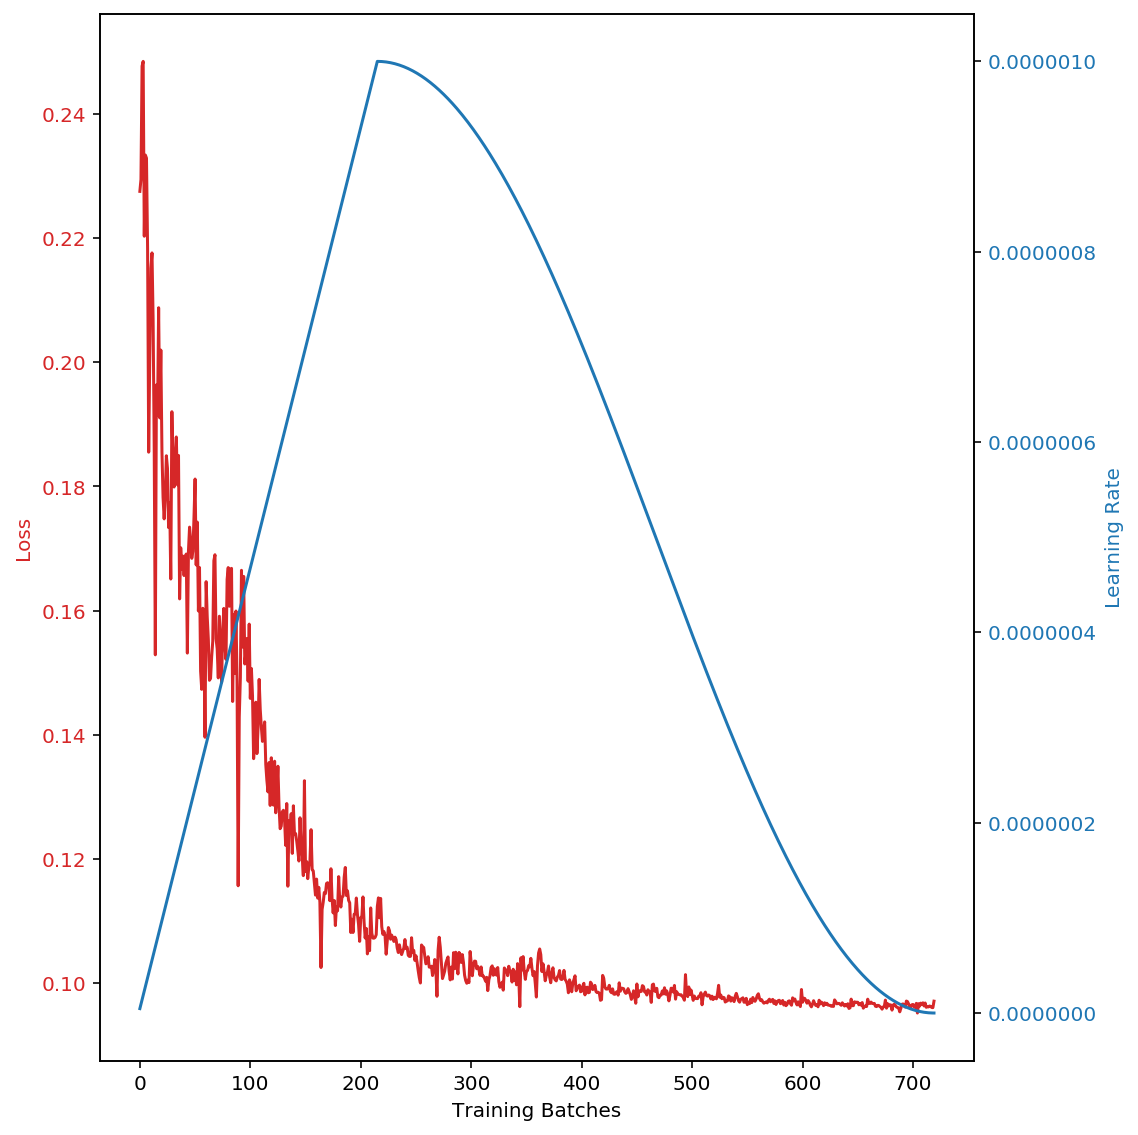

train   val
mean_or_std metric               
mean        map       0.659 0.635
            accuracy  0.633 0.634
            auc       0.757 0.749
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.633  1.000 0.776 4560.000     0.634  1.000 0.776 1140.000
pos     1.000  0.000 0.001 2640.000     1.000  0.002 0.003  660.000

In [8]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=4.75,
                              dropout=0.25,
                              word_masking_proba=0.25,
                              internal_dims=512,
                              final_layer_builder=fb_detr_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=96,
                              featurizer="transformer",
                              model='distilroberta-base',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.759	0.752 (0.717	0.716)
# 0.0.760	0.745 (725	0.721) # 15m 41s


### Actibus/Bert_REview

In [ ]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "9": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "10": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "11": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=7.25,
                              dropout=0.175,
                              word_masking_proba=0.275,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model="activebus/BERT_Review"),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.748	0.742 (0.717	0.704)


In [ ]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "9": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "10": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "11": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                }
            }
        },
    }
}


model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=6.75,
                              dropout=0.175,
                              word_masking_proba=0.25,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model="activebus/BERT_Review"),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.759	0.752 (0.717	0.716)

# 0.0.760	0.745 (725	0.721) # 15m 41s


## MLM Finetune only

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.405933 LR = 0.00000007



Epoch =  2 Loss = 0.402387 LR = 0.00000014



Epoch =  3 Loss = 0.396804 LR = 0.00000021



Epoch =  4 Loss = 0.361454 LR = 0.00000028
Epoch =  4 Train = 0.628692 Val = 0.642245



Epoch =  5 Loss = 0.324780 LR = 0.00000035



Epoch =  6 Loss = 0.313004 LR = 0.00000042



Epoch =  7 Loss = 0.306607 LR = 0.00000049
Epoch =  7 Train = 0.631743 Val = 0.642168



Epoch =  8 Loss = 0.300342 LR = 0.00000056



Epoch =  9 Loss = 0.274422 LR = 0.00000062
Epoch =  9 Train = 0.655270 Val = 0.657628



Epoch =  10 Loss = 0.272907 LR = 0.00000069



Epoch =  11 Loss = 0.252483 LR = 0.00000076
Epoch =  11 Train = 0.693603 Val = 0.676615



Epoch =  12 Loss = 0.231375 LR = 0.00000083



Epoch =  13 Loss = 0.239452 LR = 0.00000090



Epoch =  14 Loss = 0.222644 LR = 0.00000097
Epoch =  14 Train = 0.722885 Val = 0.688503



Epoch =  15 Loss = 0.219830 LR = 0.00000100



Epoch =  16 Loss = 0.218904 LR = 0.00000099



Epoch =  17 Loss = 0.221277 LR = 0.00000099
Epoch =  17 Train = 0.740617 Val = 0.715956



Epoch =  18 Loss = 0.213070 LR = 0.00000097



Epoch =  19 Loss = 0.200531 LR = 0.00000095
Epoch =  19 Train = 0.748492 Val = 0.717745



Epoch =  20 Loss = 0.197305 LR = 0.00000093



Epoch =  21 Loss = 0.189886 LR = 0.00000091



Epoch =  22 Loss = 0.204401 LR = 0.00000088



Epoch =  23 Loss = 0.197746 LR = 0.00000085
Epoch =  23 Train = 0.747336 Val = 0.713233



Epoch =  24 Loss = 0.197438 LR = 0.00000081



Epoch =  25 Loss = 0.181806 LR = 0.00000077



Epoch =  26 Loss = 0.180425 LR = 0.00000073



Epoch =  27 Loss = 0.163356 LR = 0.00000069
Epoch =  27 Train = 0.753308 Val = 0.718445



Epoch =  28 Loss = 0.165564 LR = 0.00000065



Epoch =  29 Loss = 0.159268 LR = 0.00000060



Epoch =  30 Loss = 0.157728 LR = 0.00000056



Epoch =  31 Loss = 0.151395 LR = 0.00000051
Epoch =  31 Train = 0.756965 Val = 0.722876



Epoch =  32 Loss = nan LR = 0.00000046



Epoch =  33 Loss = 0.148282 LR = 0.00000042



Epoch =  34 Loss = 0.146016 LR = 0.00000037
Epoch =  34 Train = 0.761809 Val = 0.725368



Epoch =  35 Loss = 0.138612 LR = 0.00000033



Epoch =  36 Loss = 0.142558 LR = 0.00000028



Epoch =  37 Loss = 0.143255 LR = 0.00000024
Epoch =  37 Train = 0.761787 Val = 0.723427



Epoch =  38 Loss = 0.143209 LR = 0.00000020



Epoch =  39 Loss = 0.139941 LR = 0.00000017



Epoch =  40 Loss = 0.132503 LR = 0.00000013



Epoch =  41 Loss = 0.133854 LR = 0.00000010
Epoch =  41 Train = 0.764163 Val = 0.725537



Epoch =  42 Loss = 0.130974 LR = 0.00000008



Epoch =  43 Loss = 0.131479 LR = 0.00000005



Epoch =  44 Loss = 0.133742 LR = 0.00000003
Epoch =  44 Train = 0.764582 Val = 0.725912



Epoch =  45 Loss = 0.130892 LR = 0.00000002



Epoch =  46 Loss = 0.130453 LR = 0.00000001



Epoch =  47 Loss = 0.129868 LR = 0.00000000
Epoch =  47 Train = 0.764761 Val = 0.725738



Epoch =  48 Loss = 0.129405 LR = 0.00000000



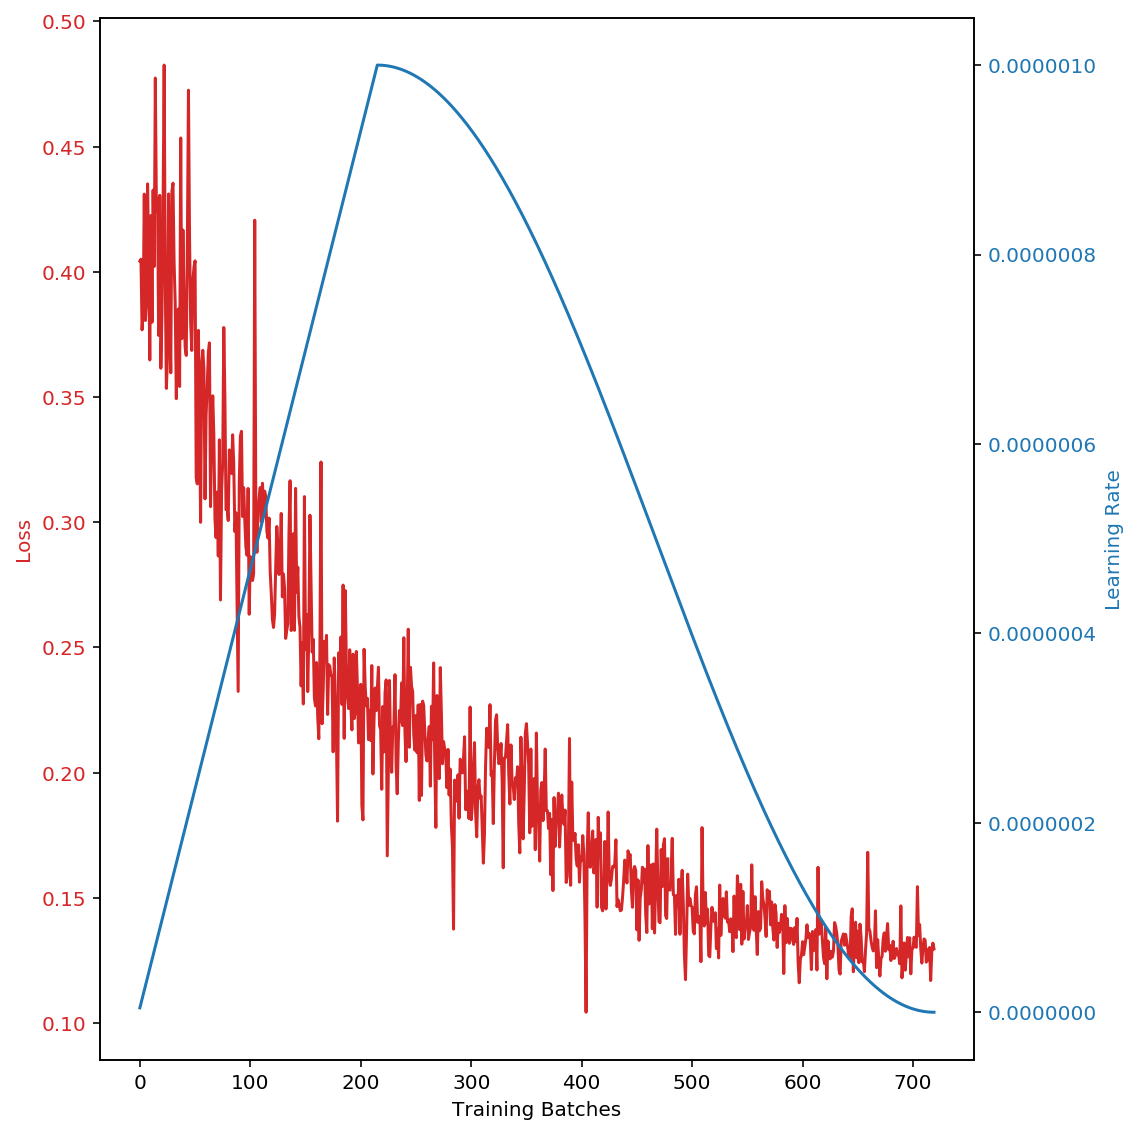

train   val
mean_or_std metric               
mean        map       0.660 0.609
            accuracy  0.729 0.706
            auc       0.765 0.726
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.738  0.889 0.806 4560.000     0.724  0.866 0.788 1140.000
pos     0.703  0.454 0.551 2640.000     0.649  0.429 0.516  660.000

In [14]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=5.25,
                              dropout=0.175,
                              internal_dims=512,
                              word_masking_proba=0.0,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.756	0.759 (0.726	0.711) # 17m 19s



## Aug Sim Finetune

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.408154 LR = 0.00000007



Epoch =  2 Loss = 0.407774 LR = 0.00000014



Epoch =  3 Loss = 0.382011 LR = 0.00000021



Epoch =  4 Loss = 0.357112 LR = 0.00000028
Epoch =  4 Train = 0.625436 Val = 0.630027



Epoch =  5 Loss = 0.342132 LR = 0.00000035



Epoch =  6 Loss = 0.318525 LR = 0.00000042



Epoch =  7 Loss = 0.308450 LR = 0.00000049
Epoch =  7 Train = 0.631297 Val = 0.633941



Epoch =  8 Loss = 0.285061 LR = 0.00000056



Epoch =  9 Loss = 0.259616 LR = 0.00000062
Epoch =  9 Train = 0.624947 Val = 0.627906



Epoch =  10 Loss = 0.250506 LR = 0.00000069



Epoch =  11 Loss = 0.248159 LR = 0.00000076
Epoch =  11 Train = 0.619619 Val = 0.623172



Epoch =  12 Loss = 0.254007 LR = 0.00000083



Epoch =  13 Loss = 0.233482 LR = 0.00000090



Epoch =  14 Loss = 0.228208 LR = 0.00000097
Epoch =  14 Train = 0.621049 Val = 0.627487



Epoch =  15 Loss = 0.228750 LR = 0.00000100



Epoch =  16 Loss = 0.226644 LR = 0.00000099



Epoch =  17 Loss = 0.220371 LR = 0.00000099
Epoch =  17 Train = 0.626332 Val = 0.629932



Epoch =  18 Loss = 0.227033 LR = 0.00000097



Epoch =  19 Loss = 0.208214 LR = 0.00000095
Epoch =  19 Train = 0.633930 Val = 0.637123



Epoch =  20 Loss = 0.199321 LR = 0.00000093



Epoch =  21 Loss = 0.200016 LR = 0.00000091



Epoch =  22 Loss = 0.187343 LR = 0.00000088



Epoch =  23 Loss = 0.179397 LR = 0.00000085
Epoch =  23 Train = 0.676848 Val = 0.677996



Epoch =  24 Loss = 0.171201 LR = 0.00000081



Epoch =  25 Loss = 0.172666 LR = 0.00000077



Epoch =  26 Loss = 0.162475 LR = 0.00000073



Epoch =  27 Loss = 0.165398 LR = 0.00000069
Epoch =  27 Train = 0.733022 Val = 0.717264



Epoch =  28 Loss = 0.156354 LR = 0.00000065



Epoch =  29 Loss = 0.148895 LR = 0.00000060



Epoch =  30 Loss = 0.149071 LR = 0.00000056



Epoch =  31 Loss = 0.149534 LR = 0.00000051
Epoch =  31 Train = 0.743630 Val = 0.717479



Epoch =  32 Loss = 0.144693 LR = 0.00000046



Epoch =  33 Loss = 0.140966 LR = 0.00000042



Epoch =  34 Loss = 0.138271 LR = 0.00000037
Epoch =  34 Train = 0.749294 Val = 0.724702



Epoch =  35 Loss = 0.132403 LR = 0.00000033



Epoch =  36 Loss = 0.135553 LR = 0.00000028



Epoch =  37 Loss = 0.131696 LR = 0.00000024
Epoch =  37 Train = 0.751952 Val = 0.730815



Epoch =  38 Loss = 0.129086 LR = 0.00000020



Epoch =  39 Loss = 0.127850 LR = 0.00000017



Epoch =  40 Loss = 0.129272 LR = 0.00000013



Epoch =  41 Loss = 0.125253 LR = 0.00000010
Epoch =  41 Train = 0.753517 Val = 0.729870



Epoch =  42 Loss = 0.129517 LR = 0.00000008



Epoch =  43 Loss = 0.124479 LR = 0.00000005



Epoch =  44 Loss = 0.125260 LR = 0.00000003
Epoch =  44 Train = 0.754592 Val = 0.731021



Epoch =  45 Loss = 0.123073 LR = 0.00000002



Epoch =  46 Loss = 0.125962 LR = 0.00000001



Epoch =  47 Loss = 0.123436 LR = 0.00000000
Epoch =  47 Train = 0.755170 Val = 0.731063



Epoch =  48 Loss = 0.126497 LR = 0.00000000



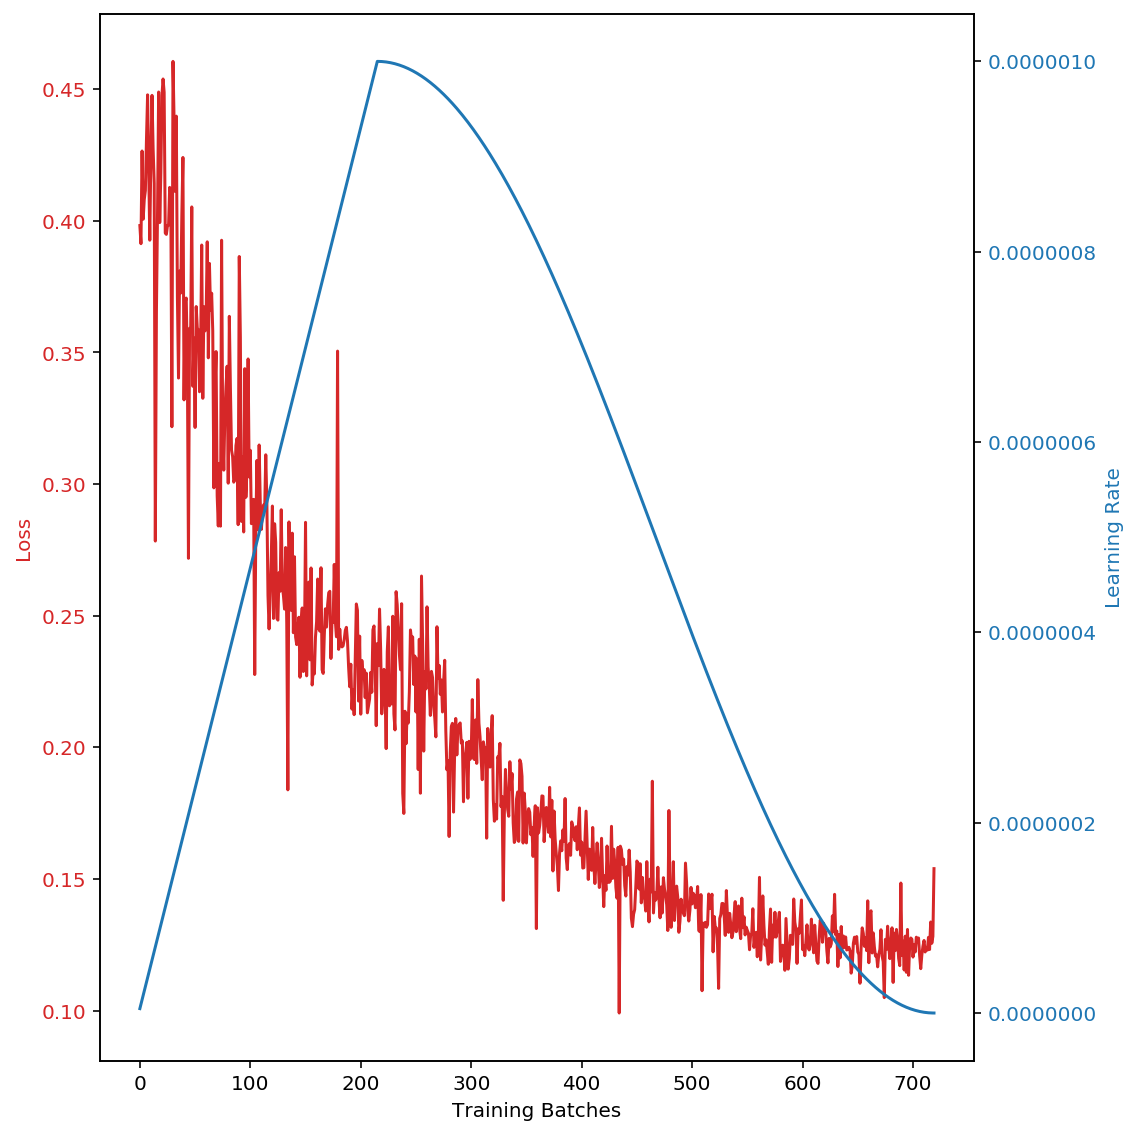

train   val
mean_or_std metric               
mean        map       0.654 0.620
            accuracy  0.724 0.713
            auc       0.755 0.731
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.736  0.880 0.802 4560.000     0.726  0.880 0.795 1140.000
pos     0.687  0.455 0.548 2640.000     0.672  0.426 0.521  660.000

In [11]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=5.25,
                              dropout=0.175,
                              word_masking_proba=0.175,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-augsim',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.754	0.738



Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.408878 LR = 0.00000007



Epoch =  2 Loss = 0.427514 LR = 0.00000014



Epoch =  3 Loss = 0.360970 LR = 0.00000021



Epoch =  4 Loss = 0.366278 LR = 0.00000028
Epoch =  4 Train = 0.629844 Val = 0.639231



Epoch =  5 Loss = 0.356487 LR = 0.00000035



Epoch =  6 Loss = 0.353455 LR = 0.00000042



Epoch =  7 Loss = 0.324090 LR = 0.00000049
Epoch =  7 Train = 0.626943 Val = 0.641511



Epoch =  8 Loss = 0.288580 LR = 0.00000056



Epoch =  9 Loss = 0.271962 LR = 0.00000062
Epoch =  9 Train = 0.624122 Val = 0.640879



Epoch =  10 Loss = 0.256748 LR = 0.00000069



Epoch =  11 Loss = 0.257634 LR = 0.00000076
Epoch =  11 Train = 0.622092 Val = 0.635004



Epoch =  12 Loss = 0.257186 LR = 0.00000083



Epoch =  13 Loss = 0.246600 LR = 0.00000090



Epoch =  14 Loss = 0.232891 LR = 0.00000097
Epoch =  14 Train = 0.628994 Val = 0.641484



Epoch =  15 Loss = 0.225693 LR = 0.00000100



Epoch =  16 Loss = 0.224021 LR = 0.00000099



Epoch =  17 Loss = 0.211169 LR = 0.00000099
Epoch =  17 Train = 0.613971 Val = 0.619171



Epoch =  18 Loss = 0.211343 LR = 0.00000097



Epoch =  19 Loss = 0.217499 LR = 0.00000095
Epoch =  19 Train = 0.626652 Val = 0.637507


Exception for:  keyboard | ' ' ' ' | ['word_cutout' 'char_delete' 'one_third_cut' 'char_swap' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  20 Loss = 0.183065 LR = 0.00000093



Epoch =  21 Loss = 0.190184 LR = 0.00000091



Epoch =  22 Loss = 0.192784 LR = 0.00000088



Epoch =  23 Loss = 0.181719 LR = 0.00000085
Epoch =  23 Train = 0.634178 Val = 0.646062



Epoch =  24 Loss = 0.185693 LR = 0.00000081



Epoch =  25 Loss = 0.169579 LR = 0.00000077



Epoch =  26 Loss = 0.176710 LR = 0.00000073



Epoch =  27 Loss = 0.173782 LR = 0.00000069
Epoch =  27 Train = 0.636524 Val = 0.648610



Epoch =  28 Loss = 0.160955 LR = 0.00000065



Epoch =  29 Loss = 0.157716 LR = 0.00000060



Epoch =  30 Loss = 0.157728 LR = 0.00000056



Epoch =  31 Loss = 0.150417 LR = 0.00000051
Epoch =  31 Train = 0.643812 Val = 0.652784



Epoch =  32 Loss = 0.150526 LR = 0.00000046



Epoch =  33 Loss = 0.144629 LR = 0.00000042



Epoch =  34 Loss = 0.143389 LR = 0.00000037
Epoch =  34 Train = 0.677279 Val = 0.676699



Epoch =  35 Loss = 0.135795 LR = 0.00000033



Epoch =  36 Loss = 0.136733 LR = 0.00000028



Epoch =  37 Loss = 0.133913 LR = 0.00000024
Epoch =  37 Train = 0.705386 Val = 0.703028



Epoch =  38 Loss = 0.131302 LR = 0.00000020



Epoch =  39 Loss = 0.129851 LR = 0.00000017



Epoch =  40 Loss = 0.131593 LR = 0.00000013



Epoch =  41 Loss = 0.130541 LR = 0.00000010
Epoch =  41 Train = 0.725506 Val = 0.715708



Epoch =  42 Loss = 0.127109 LR = 0.00000008



Epoch =  43 Loss = 0.124589 LR = 0.00000005



Epoch =  44 Loss = 0.125816 LR = 0.00000003
Epoch =  44 Train = 0.729074 Val = 0.718202



Epoch =  45 Loss = 0.122954 LR = 0.00000002



Epoch =  46 Loss = 0.123649 LR = 0.00000001



Epoch =  47 Loss = 0.122839 LR = 0.00000000
Epoch =  47 Train = 0.730187 Val = 0.718752



Epoch =  48 Loss = 0.122315 LR = 0.00000000



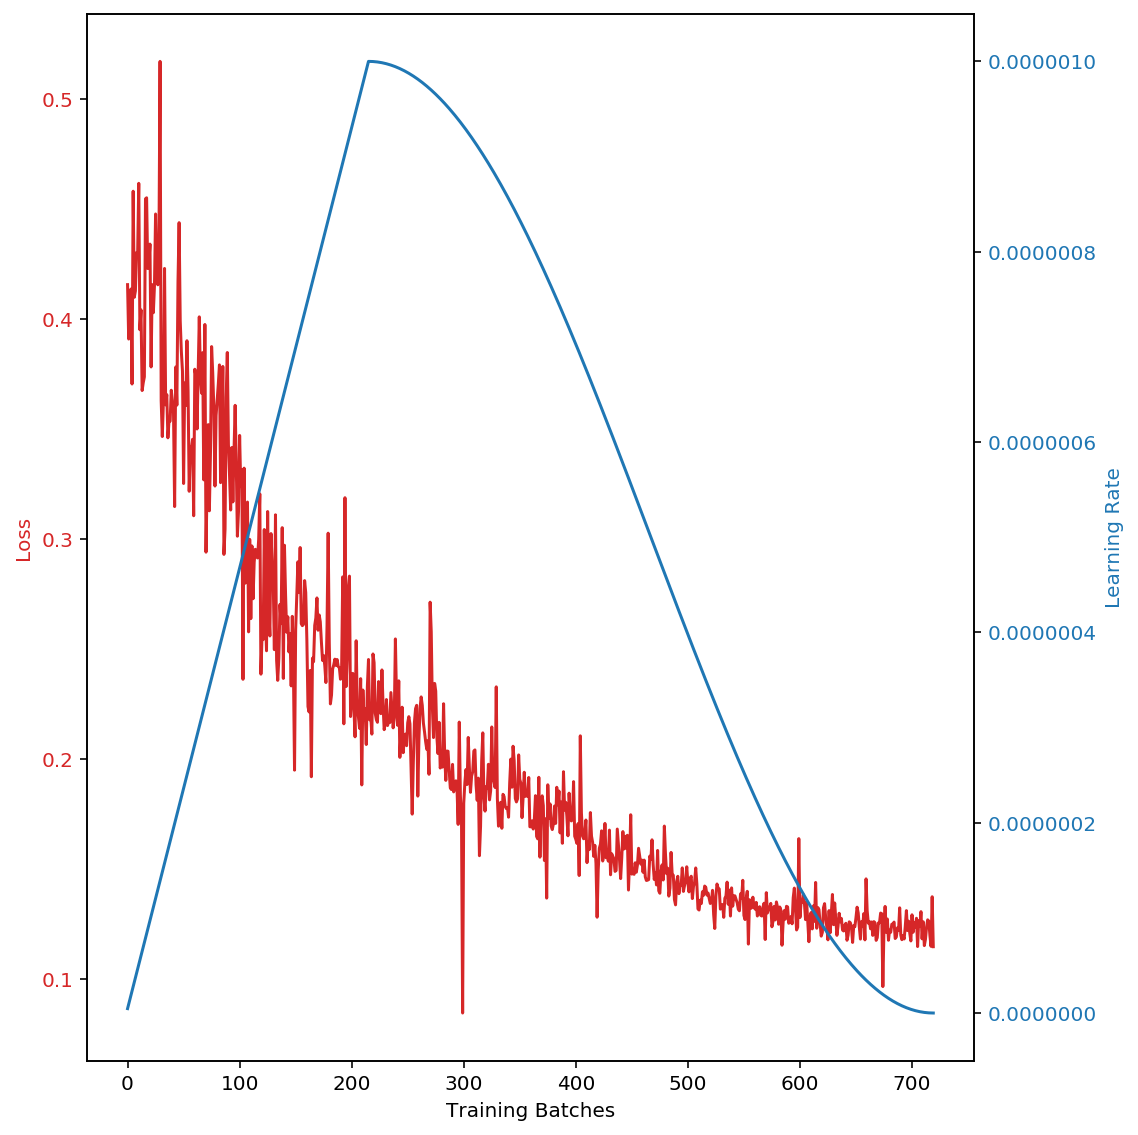

train   val
mean_or_std metric               
mean        map       0.620 0.600
            accuracy  0.705 0.701
            auc       0.730 0.719
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.740  0.822 0.779 4560.000     0.737  0.822 0.777 1140.000
pos     0.620  0.502 0.555 2640.000     0.616  0.492 0.547  660.000

In [15]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=5.5,
                              dropout=0.175,
                              word_masking_proba=0.175,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-augsim',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.754	0.738



Trainable Params = 18409984 
 AlbertClassifer(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)


Epoch =  1 Loss = 0.383328 LR = 0.00000007



Epoch =  2 Loss = 0.403650 LR = 0.00000014



Epoch =  3 Loss = 0.362909 LR = 0.00000021



Epoch =  4 Loss = 0.369468 LR = 0.00000028
Epoch =  4 Train = 0.626459 Val = 0.619172



Epoch =  5 Loss = 0.317287 LR = 0.00000035



Epoch =  6 Loss = 0.300647 LR = 0.00000042



Epoch =  7 Loss = 0.278284 LR = 0.00000049
Epoch =  7 Train = 0.619624 Val = 0.618898



Epoch =  8 Loss = 0.276798 LR = 0.00000056



Epoch =  9 Loss = 0.255808 LR = 0.00000062
Epoch =  9 Train = 0.623028 Val = 0.619121



Epoch =  10 Loss = 0.243139 LR = 0.00000069



Epoch =  11 Loss = 0.245860 LR = 0.00000076
Epoch =  11 Train = 0.612772 Val = 0.604329



Epoch =  12 Loss = 0.230906 LR = 0.00000083



Epoch =  13 Loss = 0.236096 LR = 0.00000090



Epoch =  14 Loss = 0.224642 LR = 0.00000097
Epoch =  14 Train = 0.626143 Val = 0.617079



Epoch =  15 Loss = 0.211215 LR = 0.00000100



Epoch =  16 Loss = 0.202998 LR = 0.00000099



Epoch =  17 Loss = 0.198028 LR = 0.00000099
Epoch =  17 Train = 0.631282 Val = 0.625057



Epoch =  18 Loss = 0.198978 LR = 0.00000097



Epoch =  19 Loss = 0.190162 LR = 0.00000095
Epoch =  19 Train = 0.627111 Val = 0.622440



Epoch =  20 Loss = 0.201046 LR = 0.00000093



Epoch =  21 Loss = 0.182912 LR = 0.00000091



Epoch =  22 Loss = 0.180823 LR = 0.00000088



Epoch =  23 Loss = 0.178265 LR = 0.00000085
Epoch =  23 Train = 0.644682 Val = 0.638115



Epoch =  24 Loss = 0.171057 LR = 0.00000081



Epoch =  25 Loss = 0.167995 LR = 0.00000077



Epoch =  26 Loss = 0.159687 LR = 0.00000073



Epoch =  27 Loss = 0.156779 LR = 0.00000069
Epoch =  27 Train = 0.661952 Val = 0.652318



Epoch =  28 Loss = 0.153268 LR = 0.00000065



Epoch =  29 Loss = 0.150782 LR = 0.00000060



Epoch =  30 Loss = 0.147517 LR = 0.00000056



Epoch =  31 Loss = 0.145383 LR = 0.00000051
Epoch =  31 Train = 0.714201 Val = 0.706907


Exception for:  keyboard | '' '' | ['word_cutout' 'half_cut' 'sentence_shuffle' 'text_rotate' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  32 Loss = 0.145649 LR = 0.00000046



Epoch =  33 Loss = 0.139105 LR = 0.00000042



Epoch =  34 Loss = 0.138615 LR = 0.00000037
Epoch =  34 Train = 0.722254 Val = 0.718054



Epoch =  35 Loss = 0.133207 LR = 0.00000033



Epoch =  36 Loss = 0.131492 LR = 0.00000028



Epoch =  37 Loss = 0.133239 LR = 0.00000024
Epoch =  37 Train = 0.731486 Val = 0.724367



Epoch =  38 Loss = 0.128482 LR = 0.00000020



Epoch =  39 Loss = 0.128637 LR = 0.00000017



Epoch =  40 Loss = 0.125897 LR = 0.00000013



Epoch =  41 Loss = 0.125000 LR = 0.00000010
Epoch =  41 Train = 0.739036 Val = 0.727126



Epoch =  42 Loss = 0.124794 LR = 0.00000008



Epoch =  43 Loss = 0.121976 LR = 0.00000005



Epoch =  44 Loss = 0.122874 LR = 0.00000003
Epoch =  44 Train = 0.740443 Val = 0.729244



Epoch =  45 Loss = 0.119783 LR = 0.00000002



Epoch =  46 Loss = 0.122029 LR = 0.00000001



Epoch =  47 Loss = 0.121798 LR = 0.00000000
Epoch =  47 Train = 0.740853 Val = 0.729676



Epoch =  48 Loss = 0.120025 LR = 0.00000000



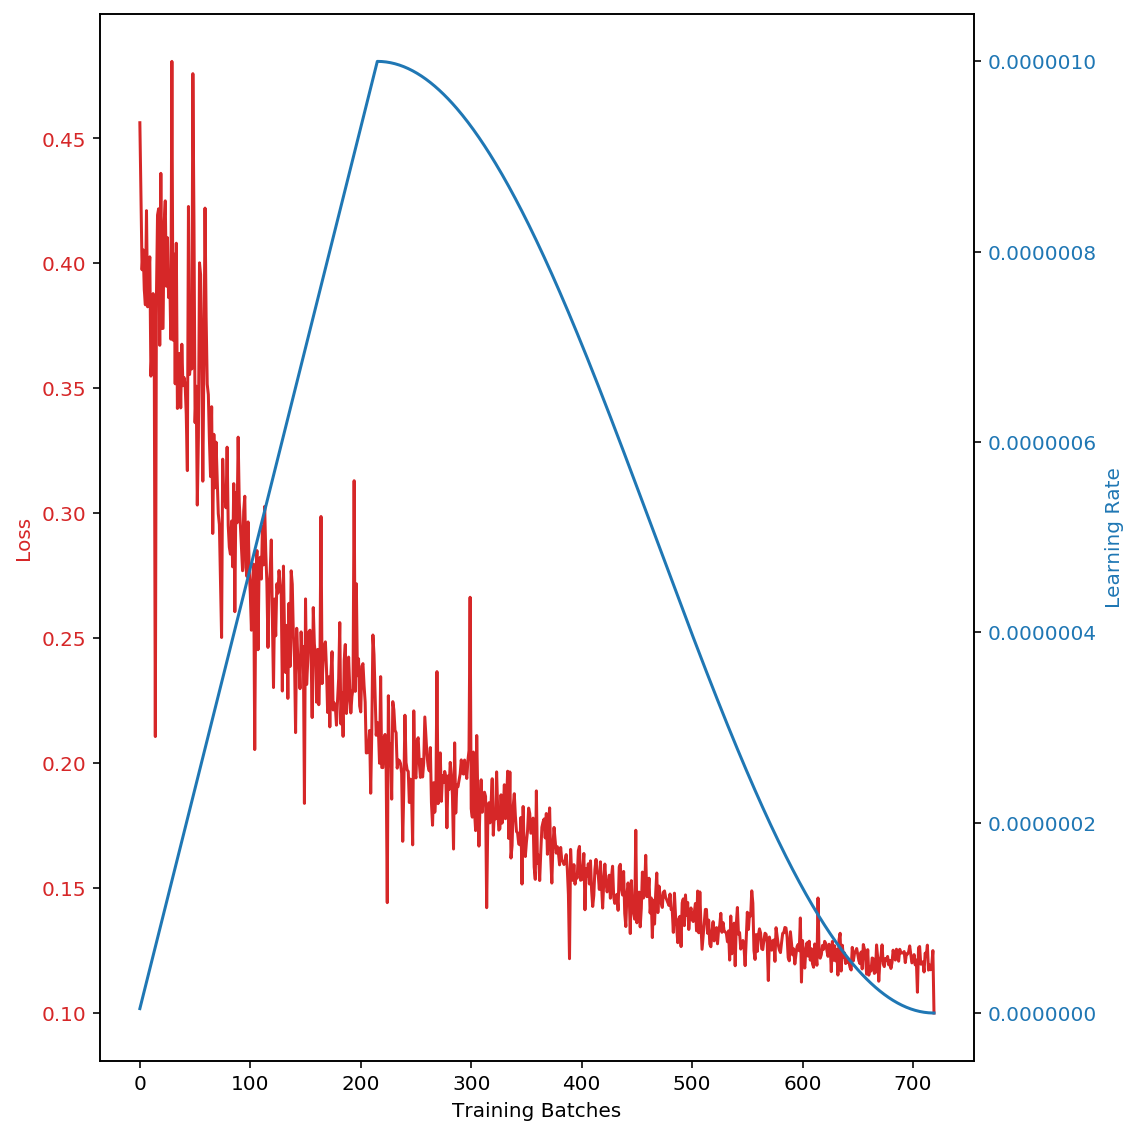

train   val
mean_or_std metric               
mean        map       0.627 0.616
            accuracy  0.711 0.711
            auc       0.741 0.730
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.725  0.876 0.793 4560.000     0.724  0.879 0.794 1140.000
pos     0.665  0.426 0.520 2640.000     0.668  0.421 0.517  660.000

In [18]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=5.25,
                              dropout=0.15,
                              word_masking_proba=0.175,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=3,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-augsim',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=True,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.754	0.738



## NSP Style Finetuned

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 1.172570 LR = 0.00000007



Epoch =  2 Loss = 0.448051 LR = 0.00000014



Epoch =  3 Loss = 0.296903 LR = 0.00000021



Epoch =  4 Loss = 0.263882 LR = 0.00000028


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.421  0.420 0.395 0.466       0.000  0.000 0.000 0.000
1.000        0.425  0.424 0.396 0.460       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
2936,0.415,0.000,0.000
1456,0.419,0.000,0.000
58,0.433,0.000,0.000
4591,0.416,0.000,0.000
1432,0.417,0.000,0.000
5156,0.409,0.000,0.000
4194,0.423,0.000,0.000
4188,0.412,0.000,0.000
3389,0.419,0.000,0.000
2793,0.429,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.421  0.420 0.399 0.468       0.000  0.000 0.000 0.000
1.000        0.424  0.424 0.400 0.470       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1100,0.432,0.000,1.000
1584,0.419,0.000,0.000
1023,0.423,0.000,1.000
1379,0.427,0.000,0.000
932,0.412,0.000,0.000
1,0.437,0.000,1.000
1212,0.435,0.000,0.000
869,0.427,0.000,1.000
1582,0.422,0.000,1.000
1086,0.432,0.000,0.000


Epoch =  4 Train = 0.618752 Val = 0.609339


Exception for:  keyboard | ' ' ' ' | ['word_cutout' 'char_insert' 'one_third_cut' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  5 Loss = 0.239773 LR = 0.00000035



Epoch =  6 Loss = 0.229140 LR = 0.00000042



Epoch =  7 Loss = 0.210020 LR = 0.00000049


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.540  0.540 0.512 0.578       1.000  1.000 1.000 1.000
1.000        0.544  0.544 0.516 0.578       1.000  1.000 1.000 1.000

,Probability,Predictions,Labels
773,0.552,1.000,0.000
6375,0.540,1.000,1.000
213,0.544,1.000,0.000
2468,0.549,1.000,0.000
3466,0.534,1.000,0.000
115,0.536,1.000,0.000
1411,0.534,1.000,0.000
3784,0.554,1.000,0.000
2852,0.556,1.000,0.000
2119,0.527,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.541  0.540 0.520 0.571       1.000  1.000 1.000 1.000
1.000        0.545  0.544 0.517 0.579       1.000  1.000 1.000 1.000

,Probability,Predictions,Labels
323,0.533,1.000,0.000
1716,0.545,1.000,0.000
547,0.541,1.000,0.000
1348,0.532,1.000,0.000
1743,0.549,1.000,0.000
574,0.538,1.000,0.000
1252,0.539,1.000,0.000
1310,0.548,1.000,0.000
118,0.550,1.000,0.000
142,0.533,1.000,0.000


Epoch =  7 Train = 0.628672 Val = 0.627489



Epoch =  8 Loss = 0.202231 LR = 0.00000056



Epoch =  9 Loss = 0.208481 LR = 0.00000062


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.410  0.410 0.386 0.453       0.000  0.000 0.000 0.000
1.000        0.415  0.415 0.388 0.461       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
6200,0.415,0.000,1.000
5301,0.396,0.000,1.000
4776,0.403,0.000,0.000
161,0.404,0.000,0.000
856,0.404,0.000,0.000
1155,0.415,0.000,0.000
5106,0.411,0.000,0.000
6333,0.404,0.000,0.000
4232,0.406,0.000,0.000
1018,0.425,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.411  0.410 0.387 0.442       0.000  0.000 0.000 0.000
1.000        0.415  0.415 0.388 0.456       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1068,0.413,0.000,0.000
418,0.399,0.000,0.000
1798,0.419,0.000,1.000
958,0.417,0.000,1.000
925,0.428,0.000,1.000
1478,0.432,0.000,0.000
1006,0.412,0.000,0.000
1143,0.407,0.000,0.000
246,0.403,0.000,0.000
139,0.401,0.000,1.000


Epoch =  9 Train = 0.647516 Val = 0.634519



Epoch =  10 Loss = 0.205151 LR = 0.00000069



Epoch =  11 Loss = 0.190524 LR = 0.00000076


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.388  0.387 0.363 0.422       0.000  0.000 0.000 0.000
1.000        0.392  0.392 0.367 0.423       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
4625,0.391,0.000,0.000
753,0.394,0.000,1.000
3754,0.378,0.000,0.000
5594,0.378,0.000,0.000
5070,0.396,0.000,1.000
3090,0.390,0.000,1.000
1644,0.384,0.000,0.000
4407,0.394,0.000,1.000
5174,0.384,0.000,1.000
2368,0.382,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.388  0.388 0.368 0.415       0.000  0.000 0.000 0.000
1.000        0.392  0.392 0.364 0.423       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1687,0.394,0.000,0.000
857,0.390,0.000,1.000
1313,0.399,0.000,1.000
1535,0.388,0.000,0.000
1397,0.396,0.000,1.000
1113,0.385,0.000,0.000
835,0.380,0.000,0.000
807,0.387,0.000,1.000
1683,0.379,0.000,0.000
379,0.403,0.000,1.000


Epoch =  11 Train = 0.644942 Val = 0.633220



Epoch =  12 Loss = 0.203845 LR = 0.00000083



Epoch =  13 Loss = 0.196110 LR = 0.00000090



Epoch =  14 Loss = 0.186066 LR = 0.00000097


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.490  0.489 0.403 0.584       0.393  0.000 0.000 1.000
1.000        0.509  0.511 0.411 0.588       0.613  1.000 0.000 1.000

,Probability,Predictions,Labels
3584,0.554,1.000,1.000
4152,0.449,0.000,0.000
1830,0.478,0.000,0.000
5076,0.491,0.000,1.000
4616,0.519,1.000,0.000
471,0.444,0.000,0.000
567,0.447,0.000,0.000
2185,0.500,0.000,0.000
4439,0.489,0.000,1.000
2166,0.539,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.491  0.490 0.416 0.573       0.400  0.000 0.000 1.000
1.000        0.508  0.511 0.411 0.587       0.603  1.000 0.000 1.000

,Probability,Predictions,Labels
1219,0.523,1.000,0.000
6,0.549,1.000,1.000
1205,0.511,1.000,1.000
1176,0.454,0.000,1.000
570,0.530,1.000,1.000
471,0.444,0.000,1.000
1004,0.465,0.000,0.000
1170,0.468,0.000,0.000
1705,0.534,1.000,1.000
887,0.486,0.000,1.000


Epoch =  14 Train = 0.648128 Val = 0.635315



Epoch =  15 Loss = 0.182890 LR = 0.00000100



Epoch =  16 Loss = 0.179778 LR = 0.00000099



Epoch =  17 Loss = 0.183716 LR = 0.00000099


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.483  0.480 0.429 0.566       0.265  0.000 0.000 1.000
1.000        0.501  0.503 0.433 0.569       0.541  1.000 0.000 1.000

,Probability,Predictions,Labels
2209,0.497,0.000,1.000
6039,0.467,0.000,0.000
6438,0.475,0.000,0.000
255,0.453,0.000,0.000
1391,0.450,0.000,1.000
3985,0.526,1.000,0.000
4195,0.526,1.000,1.000
4970,0.504,1.000,1.000
3776,0.535,1.000,0.000
5062,0.461,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.482 0.433 0.568       0.273  0.000 0.000 1.000
1.000        0.501  0.502 0.434 0.565       0.527  1.000 0.000 1.000

,Probability,Predictions,Labels
1239,0.477,0.000,1.000
691,0.484,0.000,0.000
91,0.509,1.000,1.000
194,0.518,1.000,1.000
110,0.543,1.000,1.000
396,0.519,1.000,0.000
1475,0.456,0.000,0.000
1721,0.486,0.000,1.000
298,0.518,1.000,1.000
1224,0.501,1.000,0.000


Epoch =  17 Train = 0.688498 Val = 0.672431



Epoch =  18 Loss = 0.175307 LR = 0.00000097



Epoch =  19 Loss = 0.170251 LR = 0.00000095


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.470  0.460 0.402 0.636       0.216  0.000 0.000 1.000
1.000        0.513  0.508 0.404 0.642       0.539  1.000 0.000 1.000

,Probability,Predictions,Labels
1850,0.485,0.000,0.000
4662,0.483,0.000,1.000
6095,0.568,1.000,0.000
6955,0.534,1.000,0.000
1463,0.458,0.000,1.000
6184,0.449,0.000,0.000
1256,0.468,0.000,1.000
1451,0.464,0.000,1.000
856,0.473,0.000,1.000
4133,0.505,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.472  0.462 0.403 0.642       0.221  0.000 0.000 1.000
1.000        0.513  0.503 0.407 0.637       0.526  1.000 0.000 1.000

,Probability,Predictions,Labels
766,0.449,0.000,1.000
1505,0.564,1.000,0.000
1510,0.417,0.000,0.000
250,0.458,0.000,1.000
310,0.458,0.000,1.000
1698,0.534,1.000,1.000
616,0.447,0.000,0.000
1438,0.552,1.000,0.000
298,0.411,0.000,0.000
204,0.436,0.000,0.000


Epoch =  19 Train = 0.724270 Val = 0.710122



Epoch =  20 Loss = 0.168645 LR = 0.00000093



Epoch =  21 Loss = 0.168592 LR = 0.00000091



Epoch =  22 Loss = 0.165793 LR = 0.00000088



Epoch =  23 Loss = 0.167767 LR = 0.00000085


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.455  0.436 0.394 0.591       0.196  0.000 0.000 1.000
1.000        0.504  0.518 0.397 0.598       0.544  1.000 0.000 1.000

,Probability,Predictions,Labels
3705,0.462,0.000,0.000
1429,0.545,1.000,0.000
3608,0.432,0.000,0.000
575,0.579,1.000,1.000
4451,0.437,0.000,0.000
1228,0.433,0.000,0.000
3450,0.552,1.000,0.000
1369,0.540,1.000,1.000
123,0.548,1.000,1.000
5656,0.421,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.458  0.438 0.395 0.586       0.214  0.000 0.000 1.000
1.000        0.503  0.512 0.400 0.598       0.533  1.000 0.000 1.000

,Probability,Predictions,Labels
1476,0.520,1.000,0.000
717,0.463,0.000,1.000
1118,0.567,1.000,1.000
323,0.433,0.000,1.000
1374,0.408,0.000,0.000
418,0.503,1.000,0.000
79,0.407,0.000,0.000
924,0.434,0.000,1.000
1373,0.428,0.000,0.000
143,0.457,0.000,1.000


Epoch =  23 Train = 0.740138 Val = 0.724673



Epoch =  24 Loss = 0.164263 LR = 0.00000081



Epoch =  25 Loss = 0.167155 LR = 0.00000077



Epoch =  26 Loss = 0.162040 LR = 0.00000073



Epoch =  27 Loss = 0.162767 LR = 0.00000069


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.437  0.416 0.367 0.599       0.169  0.000 0.000 1.000
1.000        0.499  0.507 0.372 0.603       0.517  1.000 0.000 1.000

,Probability,Predictions,Labels
1430,0.392,0.000,0.000
4434,0.374,0.000,0.000
2783,0.577,1.000,1.000
4913,0.413,0.000,0.000
3326,0.415,0.000,0.000
1095,0.452,0.000,1.000
4581,0.378,0.000,0.000
6435,0.588,1.000,1.000
1116,0.404,0.000,0.000
1187,0.466,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.441  0.419 0.365 0.596       0.193  0.000 0.000 1.000
1.000        0.499  0.510 0.376 0.602       0.527  1.000 0.000 1.000

,Probability,Predictions,Labels
1728,0.419,0.000,0.000
929,0.558,1.000,0.000
1217,0.506,1.000,0.000
1333,0.381,0.000,0.000
1678,0.413,0.000,1.000
895,0.433,0.000,1.000
1713,0.473,0.000,1.000
249,0.556,1.000,0.000
600,0.377,0.000,0.000
40,0.392,0.000,0.000


Epoch =  27 Train = 0.752057 Val = 0.734929



Epoch =  28 Loss = 0.163241 LR = 0.00000065



Epoch =  29 Loss = 0.159261 LR = 0.00000060



Epoch =  30 Loss = 0.161112 LR = 0.00000056



Epoch =  31 Loss = 0.159323 LR = 0.00000051


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.441  0.426 0.329 0.619       0.181  0.000 0.000 1.000
1.000        0.511  0.516 0.345 0.624       0.548  1.000 0.000 1.000

,Probability,Predictions,Labels
156,0.366,0.000,0.000
388,0.442,0.000,0.000
3311,0.438,0.000,0.000
3521,0.381,0.000,0.000
1089,0.610,1.000,0.000
3438,0.569,1.000,0.000
2585,0.407,0.000,0.000
5404,0.477,0.000,1.000
3193,0.603,1.000,0.000
2873,0.426,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.446  0.431 0.329 0.618       0.201  0.000 0.000 1.000
1.000        0.509  0.513 0.352 0.624       0.536  1.000 0.000 1.000

,Probability,Predictions,Labels
1646,0.616,1.000,1.000
1412,0.477,0.000,0.000
981,0.569,1.000,1.000
1465,0.446,0.000,0.000
1162,0.600,1.000,1.000
1748,0.465,0.000,1.000
1279,0.381,0.000,0.000
1569,0.426,0.000,0.000
405,0.575,1.000,0.000
1531,0.440,0.000,0.000


Epoch =  31 Train = 0.759620 Val = 0.736903



Epoch =  32 Loss = 0.160796 LR = 0.00000046



Epoch =  33 Loss = 0.163553 LR = 0.00000042



Epoch =  34 Loss = 0.161724 LR = 0.00000037


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.459  0.448 0.329 0.624       0.215  0.000 0.000 1.000
1.000        0.528  0.534 0.356 0.628       0.600  1.000 0.000 1.000

,Probability,Predictions,Labels
4177,0.478,0.000,0.000
5385,0.575,1.000,1.000
677,0.452,0.000,0.000
6348,0.386,0.000,0.000
3978,0.397,0.000,0.000
5124,0.442,0.000,0.000
4532,0.441,0.000,0.000
2072,0.399,0.000,0.000
16,0.603,1.000,1.000
1735,0.479,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.464  0.453 0.330 0.622       0.241  0.000 0.000 1.000
1.000        0.526  0.532 0.369 0.626       0.597  1.000 0.000 1.000

,Probability,Predictions,Labels
698,0.478,0.000,0.000
1746,0.383,0.000,0.000
500,0.409,0.000,0.000
1253,0.478,0.000,0.000
503,0.410,0.000,0.000
889,0.431,0.000,0.000
1068,0.554,1.000,1.000
973,0.476,0.000,0.000
805,0.407,0.000,0.000
161,0.548,1.000,1.000


Epoch =  34 Train = 0.765022 Val = 0.740406



Epoch =  35 Loss = 0.159198 LR = 0.00000033



Epoch =  36 Loss = 0.160290 LR = 0.00000028



Epoch =  37 Loss = 0.160195 LR = 0.00000024


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.461  0.451 0.329 0.632       0.216  0.000 0.000 1.000
1.000        0.530  0.535 0.363 0.636       0.612  1.000 0.000 1.000

,Probability,Predictions,Labels
60,0.583,1.000,0.000
6163,0.450,0.000,0.000
4691,0.348,0.000,0.000
6454,0.521,1.000,0.000
1007,0.577,1.000,0.000
5560,0.607,1.000,1.000
4748,0.552,1.000,0.000
6259,0.459,0.000,0.000
710,0.462,0.000,1.000
2822,0.479,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.466  0.455 0.332 0.628       0.246  0.000 0.000 1.000
1.000        0.528  0.532 0.376 0.636       0.592  1.000 0.000 1.000

,Probability,Predictions,Labels
299,0.386,0.000,0.000
661,0.465,0.000,0.000
722,0.480,0.000,0.000
291,0.592,1.000,1.000
326,0.619,1.000,1.000
4,0.538,1.000,0.000
963,0.426,0.000,0.000
1299,0.391,0.000,0.000
1506,0.458,0.000,1.000
151,0.474,0.000,1.000


Epoch =  37 Train = 0.768798 Val = 0.742675



Epoch =  38 Loss = 0.157420 LR = 0.00000020



Epoch =  39 Loss = 0.160227 LR = 0.00000017



Epoch =  40 Loss = 0.161024 LR = 0.00000013



Epoch =  41 Loss = 0.160153 LR = 0.00000010


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.474  0.462 0.319 0.652       0.299  0.000 0.000 1.000
1.000        0.554  0.570 0.351 0.657       0.706  1.000 0.000 1.000

,Probability,Predictions,Labels
5110,0.548,1.000,0.000
257,0.433,0.000,0.000
925,0.446,0.000,1.000
3225,0.388,0.000,0.000
1908,0.592,1.000,1.000
5791,0.481,0.000,0.000
691,0.436,0.000,1.000
1226,0.480,0.000,0.000
4630,0.623,1.000,1.000
3328,0.411,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.479  0.469 0.322 0.650       0.329  0.000 0.000 1.000
1.000        0.551  0.569 0.368 0.657       0.683  1.000 0.000 1.000

,Probability,Predictions,Labels
822,0.442,0.000,0.000
1374,0.633,1.000,0.000
635,0.380,0.000,0.000
111,0.652,1.000,1.000
236,0.541,1.000,1.000
668,0.474,0.000,1.000
1552,0.501,1.000,0.000
307,0.536,1.000,1.000
1669,0.385,0.000,0.000
312,0.438,0.000,0.000


Epoch =  41 Train = 0.771398 Val = 0.744032



Epoch =  42 Loss = 0.157518 LR = 0.00000008



Epoch =  43 Loss = 0.162114 LR = 0.00000005



Epoch =  44 Loss = 0.156563 LR = 0.00000003


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.466  0.453 0.318 0.647       0.275  0.000 0.000 1.000
1.000        0.546  0.563 0.346 0.652       0.685  1.000 0.000 1.000

,Probability,Predictions,Labels
3293,0.629,1.000,0.000
4636,0.613,1.000,1.000
2038,0.399,0.000,0.000
3654,0.456,0.000,0.000
3720,0.493,0.000,0.000
4644,0.420,0.000,0.000
3942,0.622,1.000,1.000
3458,0.533,1.000,0.000
3807,0.447,0.000,0.000
2846,0.477,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.472  0.460 0.322 0.645       0.302  0.000 0.000 1.000
1.000        0.543  0.562 0.363 0.652       0.664  1.000 0.000 1.000

,Probability,Predictions,Labels
1727,0.523,1.000,0.000
1276,0.479,0.000,1.000
824,0.499,0.000,1.000
139,0.384,0.000,0.000
881,0.433,0.000,0.000
944,0.639,1.000,1.000
494,0.566,1.000,0.000
1419,0.402,0.000,1.000
269,0.486,0.000,0.000
182,0.630,1.000,1.000


Epoch =  44 Train = 0.772472 Val = 0.743868



Epoch =  45 Loss = 0.157083 LR = 0.00000002



Epoch =  46 Loss = 0.160376 LR = 0.00000001



Epoch =  47 Loss = 0.157133 LR = 0.00000000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.462  0.447 0.304 0.654       0.270  0.000 0.000 1.000
1.000        0.547  0.565 0.332 0.659       0.681  1.000 0.000 1.000

,Probability,Predictions,Labels
1373,0.531,1.000,1.000
278,0.397,0.000,0.000
7103,0.457,0.000,0.000
5646,0.586,1.000,1.000
1607,0.397,0.000,0.000
1338,0.494,0.000,0.000
2219,0.580,1.000,0.000
4417,0.374,0.000,0.000
3003,0.559,1.000,1.000
5888,0.505,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.468  0.454 0.308 0.652       0.294  0.000 0.000 1.000
1.000        0.544  0.563 0.356 0.659       0.661  1.000 0.000 1.000

,Probability,Predictions,Labels
726,0.479,0.000,1.000
1549,0.600,1.000,1.000
1526,0.523,1.000,1.000
724,0.608,1.000,0.000
1363,0.616,1.000,0.000
1168,0.552,1.000,1.000
482,0.624,1.000,1.000
1331,0.480,0.000,0.000
446,0.425,0.000,0.000
1694,0.525,1.000,0.000


Epoch =  47 Train = 0.772702 Val = 0.743893



Epoch =  48 Loss = 0.159122 LR = 0.00000000



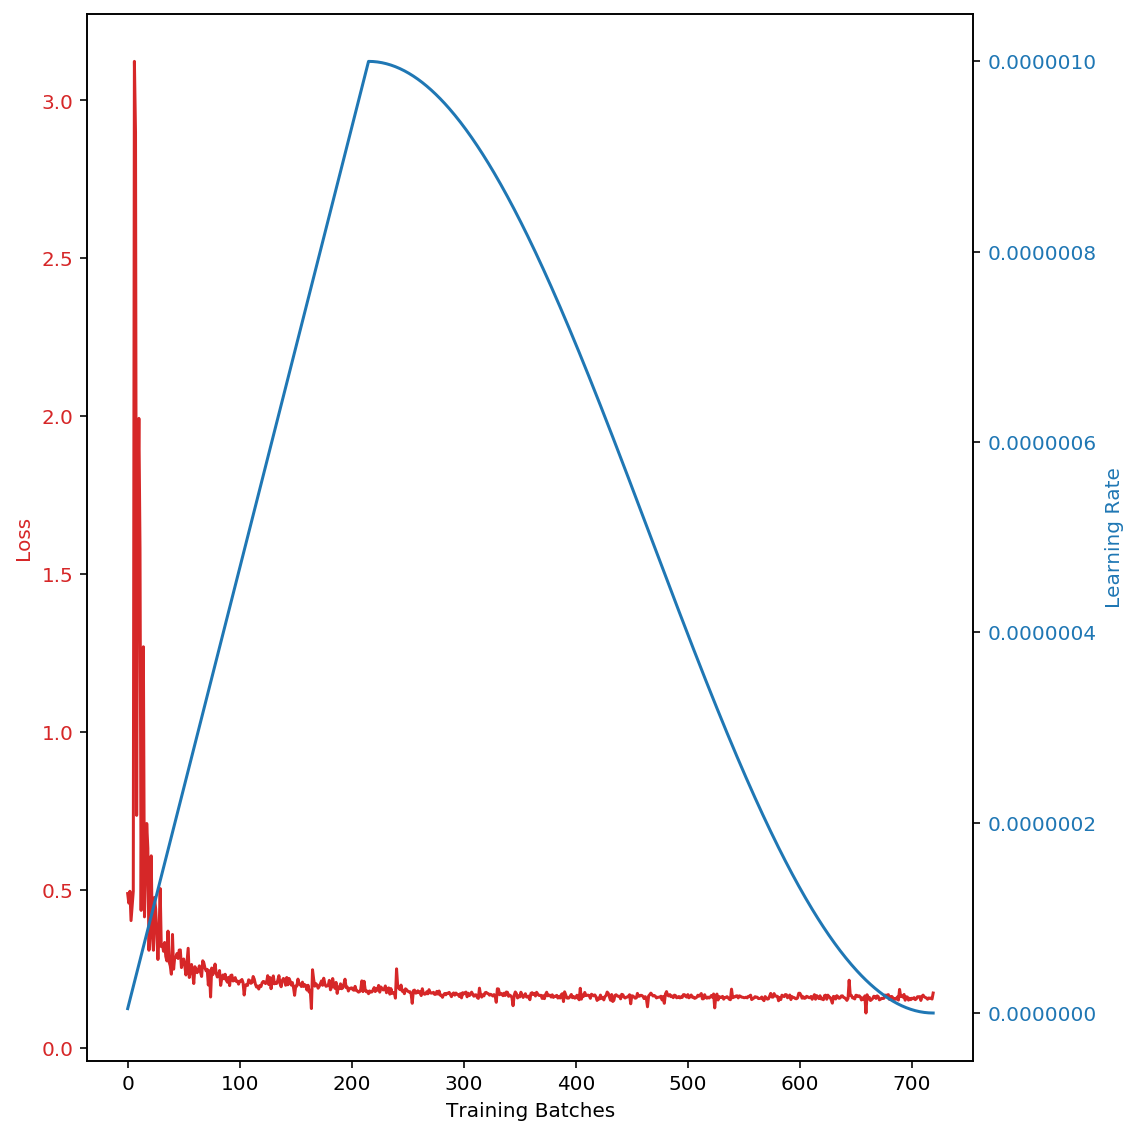

Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.468  0.454 0.308 0.652       0.291  0.000 0.000 1.000
1.000        0.543  0.563 0.356 0.659       0.659  1.000 0.000 1.000

,Probability,Predictions,Labels
1148,0.436,0.000,0.000
1514,0.370,0.000,0.000
1049,0.476,0.000,0.000
1698,0.409,0.000,0.000
1608,0.397,0.000,0.000
478,0.474,0.000,0.000
816,0.453,0.000,1.000
105,0.410,0.000,0.000
814,0.470,0.000,0.000
195,0.479,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.462  0.447 0.304 0.654       0.270  0.000 0.000 1.000
1.000        0.547  0.565 0.332 0.659       0.680  1.000 0.000 1.000

,Probability,Predictions,Labels
2034,0.368,0.000,0.000
5965,0.391,0.000,0.000
5307,0.505,1.000,0.000
1163,0.603,1.000,0.000
346,0.436,0.000,1.000
5209,0.492,0.000,1.000
2290,0.556,1.000,0.000
6047,0.379,0.000,0.000
3604,0.583,1.000,1.000
1701,0.425,0.000,0.000


train   val
mean_or_std metric               
mean        map       0.660 0.629
            accuracy  0.712 0.691
            auc       0.773 0.744
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.798  0.730 0.762 4560.000     0.782  0.709 0.744 1140.000
pos     0.593  0.680 0.634 2640.000     0.567  0.659 0.610  660.000

In [14]:
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.25,
                              dropout=0.1,
                              word_masking_proba=0.2,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs



### Overfit

In [ ]:
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=5.75,
                              dropout=0.175,
                              word_masking_proba=0.2,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              loss="classification",
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs



### Underfit

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.411033 LR = 0.00000007
Epoch =  1 Train = 0.545539 Val = 0.561614



Epoch =  2 Loss = 0.403021 LR = 0.00000014



Epoch =  3 Loss = 0.375598 LR = 0.00000021



Epoch =  4 Loss = 0.363777 LR = 0.00000028
Epoch =  4 Train = 0.626123 Val = 0.632772



Epoch =  5 Loss = 0.340902 LR = 0.00000035



Epoch =  6 Loss = 0.303469 LR = 0.00000042



Epoch =  7 Loss = 0.285836 LR = 0.00000049
Epoch =  7 Train = 0.629890 Val = 0.629718



Epoch =  8 Loss = 0.282529 LR = 0.00000056



Epoch =  9 Loss = 0.275315 LR = 0.00000062
Epoch =  9 Train = 0.620730 Val = 0.619240



Epoch =  10 Loss = 0.262211 LR = 0.00000069



Epoch =  11 Loss = 0.245556 LR = 0.00000076
Epoch =  11 Train = 0.640288 Val = 0.640667



Epoch =  12 Loss = 0.245336 LR = 0.00000083



Epoch =  13 Loss = 0.239849 LR = 0.00000090



Epoch =  14 Loss = 0.225516 LR = 0.00000097
Epoch =  14 Train = 0.623191 Val = 0.627529



Epoch =  15 Loss = 0.228426 LR = 0.00000100



Epoch =  16 Loss = 0.206770 LR = 0.00000099



Epoch =  17 Loss = 0.212978 LR = 0.00000099
Epoch =  17 Train = 0.604729 Val = 0.600066



Epoch =  18 Loss = 0.206231 LR = 0.00000097



Epoch =  19 Loss = 0.192549 LR = 0.00000095
Epoch =  19 Train = 0.560420 Val = 0.565093



Epoch =  20 Loss = 0.193900 LR = 0.00000093



Epoch =  21 Loss = 0.187726 LR = 0.00000091



Epoch =  22 Loss = 0.184535 LR = 0.00000088



Epoch =  23 Loss = 0.183911 LR = 0.00000085
Epoch =  23 Train = 0.620926 Val = 0.626705



Epoch =  24 Loss = 0.182511 LR = 0.00000081



Epoch =  25 Loss = 0.171483 LR = 0.00000077



Epoch =  26 Loss = 0.171165 LR = 0.00000073



Epoch =  27 Loss = 0.171473 LR = 0.00000069
Epoch =  27 Train = 0.514038 Val = 0.503165



Epoch =  28 Loss = 0.163622 LR = 0.00000065



Epoch =  29 Loss = 0.161524 LR = 0.00000060



Epoch =  30 Loss = 0.155011 LR = 0.00000056



Epoch =  31 Loss = 0.154819 LR = 0.00000051
Epoch =  31 Train = 0.631160 Val = 0.635066



Epoch =  32 Loss = 0.148049 LR = 0.00000046



Epoch =  33 Loss = 0.145977 LR = 0.00000042



Epoch =  34 Loss = 0.140352 LR = 0.00000037
Epoch =  34 Train = 0.636249 Val = 0.633680



Epoch =  35 Loss = 0.143258 LR = 0.00000033



Epoch =  36 Loss = 0.139840 LR = 0.00000028



Epoch =  37 Loss = 0.135083 LR = 0.00000024
Epoch =  37 Train = 0.638948 Val = 0.635819



Epoch =  38 Loss = 0.132306 LR = 0.00000020



Epoch =  39 Loss = 0.132011 LR = 0.00000017



Epoch =  40 Loss = 0.127763 LR = 0.00000013



Epoch =  41 Loss = 0.127381 LR = 0.00000010
Epoch =  41 Train = 0.638870 Val = 0.634009



Epoch =  42 Loss = 0.128026 LR = 0.00000008



Epoch =  43 Loss = 0.127079 LR = 0.00000005



Epoch =  44 Loss = 0.124470 LR = 0.00000003
Epoch =  44 Train = 0.638812 Val = 0.633791



Epoch =  45 Loss = 0.124423 LR = 0.00000002



Epoch =  46 Loss = 0.124609 LR = 0.00000001



Epoch =  47 Loss = 0.122734 LR = 0.00000000
Epoch =  47 Train = 0.639536 Val = 0.632535



Epoch =  48 Loss = 0.124931 LR = 0.00000000



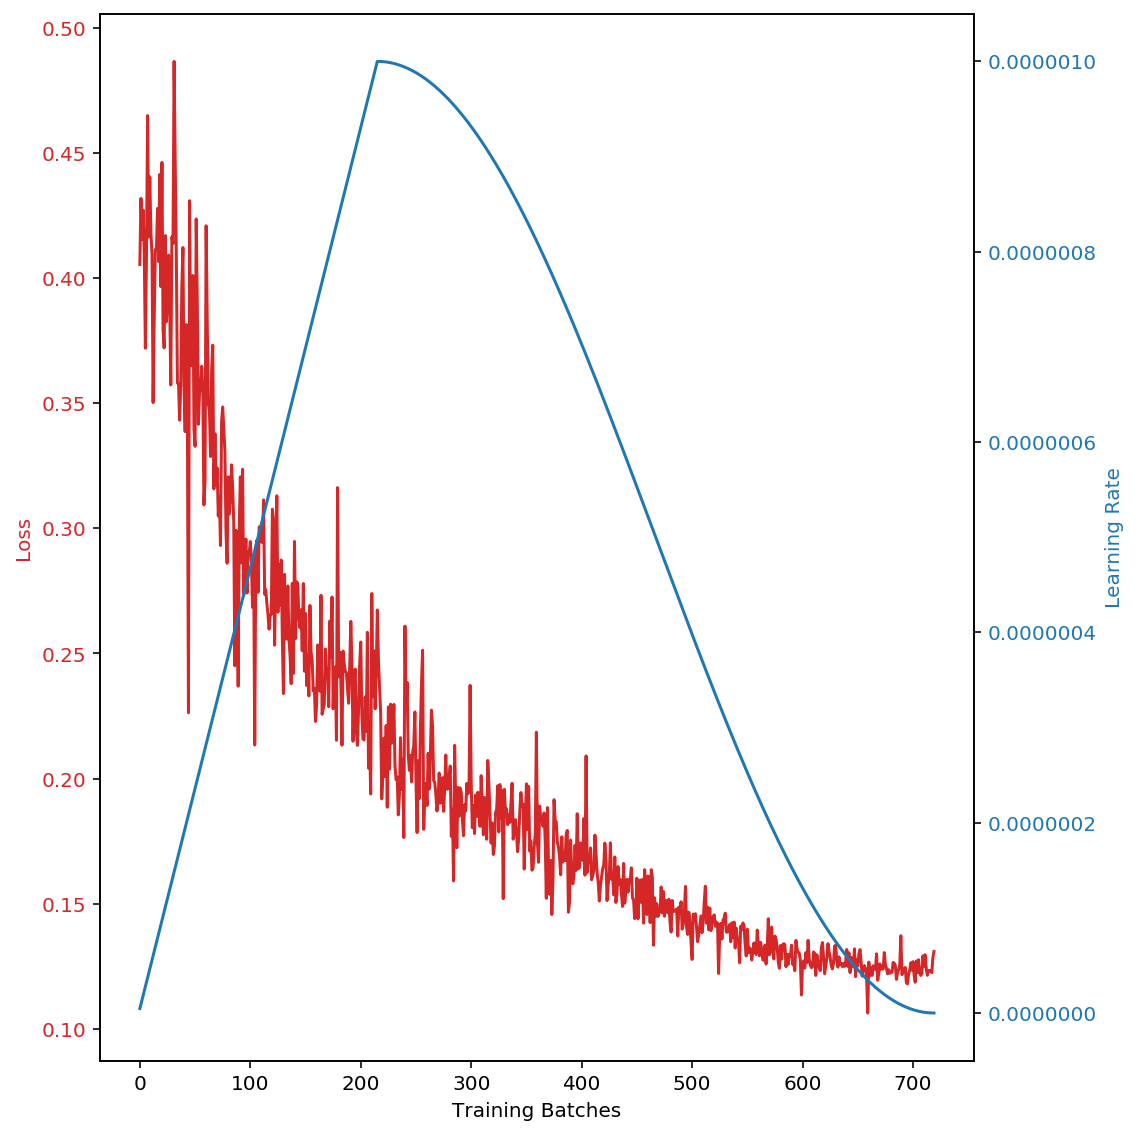

train   val
mean_or_std metric               
mean        map       0.492 0.493
            accuracy  0.633 0.633
            auc       0.640 0.635
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.633  1.000 0.776 4560.000     0.633  1.000 0.776 1140.000
pos     0.000  0.000 0.000 2640.000     0.000  0.000 0.000  660.000

In [10]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=5.5,
                              dropout=0.175,
                              word_masking_proba=0.25,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.760	0.731 (0.721	0.710)

# 0.796	0.764

# 0.808	0.751


Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.429740 LR = 0.00000007



Epoch =  2 Loss = 0.389039 LR = 0.00000014



Epoch =  3 Loss = 0.385800 LR = 0.00000021



Epoch =  4 Loss = 0.361875 LR = 0.00000028
Epoch =  4 Train = 0.639474 Val = 0.646151



Epoch =  5 Loss = 0.344160 LR = 0.00000035



Epoch =  6 Loss = 0.326081 LR = 0.00000042



Epoch =  7 Loss = 0.306715 LR = 0.00000049
Epoch =  7 Train = 0.638225 Val = 0.645494



Epoch =  8 Loss = 0.281000 LR = 0.00000056



Epoch =  9 Loss = 0.273723 LR = 0.00000062
Epoch =  9 Train = 0.648493 Val = 0.657641



Epoch =  10 Loss = 0.269668 LR = 0.00000069



Epoch =  11 Loss = 0.249881 LR = 0.00000076
Epoch =  11 Train = 0.643339 Val = 0.652476



Epoch =  12 Loss = 0.254111 LR = 0.00000083



Epoch =  13 Loss = 0.233207 LR = 0.00000090



Epoch =  14 Loss = 0.219851 LR = 0.00000097
Epoch =  14 Train = 0.652450 Val = 0.664215



Epoch =  15 Loss = 0.220044 LR = 0.00000100



Epoch =  16 Loss = 0.214951 LR = 0.00000099



Epoch =  17 Loss = 0.205945 LR = 0.00000099
Epoch =  17 Train = 0.681554 Val = 0.690839



Epoch =  18 Loss = 0.194348 LR = 0.00000097



Epoch =  19 Loss = 0.198357 LR = 0.00000095
Epoch =  19 Train = 0.701471 Val = 0.703046



Epoch =  20 Loss = 0.188514 LR = 0.00000093



Epoch =  21 Loss = 0.183175 LR = 0.00000091



Epoch =  22 Loss = 0.179789 LR = 0.00000088



Epoch =  23 Loss = 0.173327 LR = 0.00000085
Epoch =  23 Train = 0.732199 Val = 0.721560



Epoch =  24 Loss = 0.170936 LR = 0.00000081



Epoch =  25 Loss = 0.168009 LR = 0.00000077



Epoch =  26 Loss = 0.171328 LR = 0.00000073



Epoch =  27 Loss = 0.164884 LR = 0.00000069
Epoch =  27 Train = 0.752818 Val = 0.745066



Epoch =  28 Loss = 0.158356 LR = 0.00000065



Epoch =  29 Loss = 0.155296 LR = 0.00000060



Epoch =  30 Loss = 0.155850 LR = 0.00000056



Epoch =  31 Loss = 0.145470 LR = 0.00000051
Epoch =  31 Train = 0.756158 Val = 0.741417



Epoch =  32 Loss = 0.152303 LR = 0.00000046



Epoch =  33 Loss = 0.142604 LR = 0.00000042


Exception for:  keyboard | '' '' | ['half_cut' 'word_cutout' 'sentence_shuffle' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  34 Loss = 0.142973 LR = 0.00000037
Epoch =  34 Train = 0.761878 Val = 0.739674



Epoch =  35 Loss = 0.140958 LR = 0.00000033



Epoch =  36 Loss = 0.138464 LR = 0.00000028



Epoch =  37 Loss = 0.136781 LR = 0.00000024
Epoch =  37 Train = 0.766963 Val = 0.743692



Epoch =  38 Loss = 0.138767 LR = 0.00000020



Epoch =  39 Loss = 0.132474 LR = 0.00000017



Epoch =  40 Loss = 0.131148 LR = 0.00000013



Epoch =  41 Loss = 0.130004 LR = 0.00000010
Epoch =  41 Train = 0.772963 Val = 0.748995



Epoch =  42 Loss = 0.132061 LR = 0.00000008



Epoch =  43 Loss = 0.128361 LR = 0.00000005



Epoch =  44 Loss = 0.125149 LR = 0.00000003
Epoch =  44 Train = 0.773581 Val = 0.749709



Epoch =  45 Loss = 0.127819 LR = 0.00000002



Epoch =  46 Loss = 0.124453 LR = 0.00000001



Epoch =  47 Loss = 0.127397 LR = 0.00000000
Epoch =  47 Train = 0.773709 Val = 0.749591



Epoch =  48 Loss = 0.127369 LR = 0.00000000



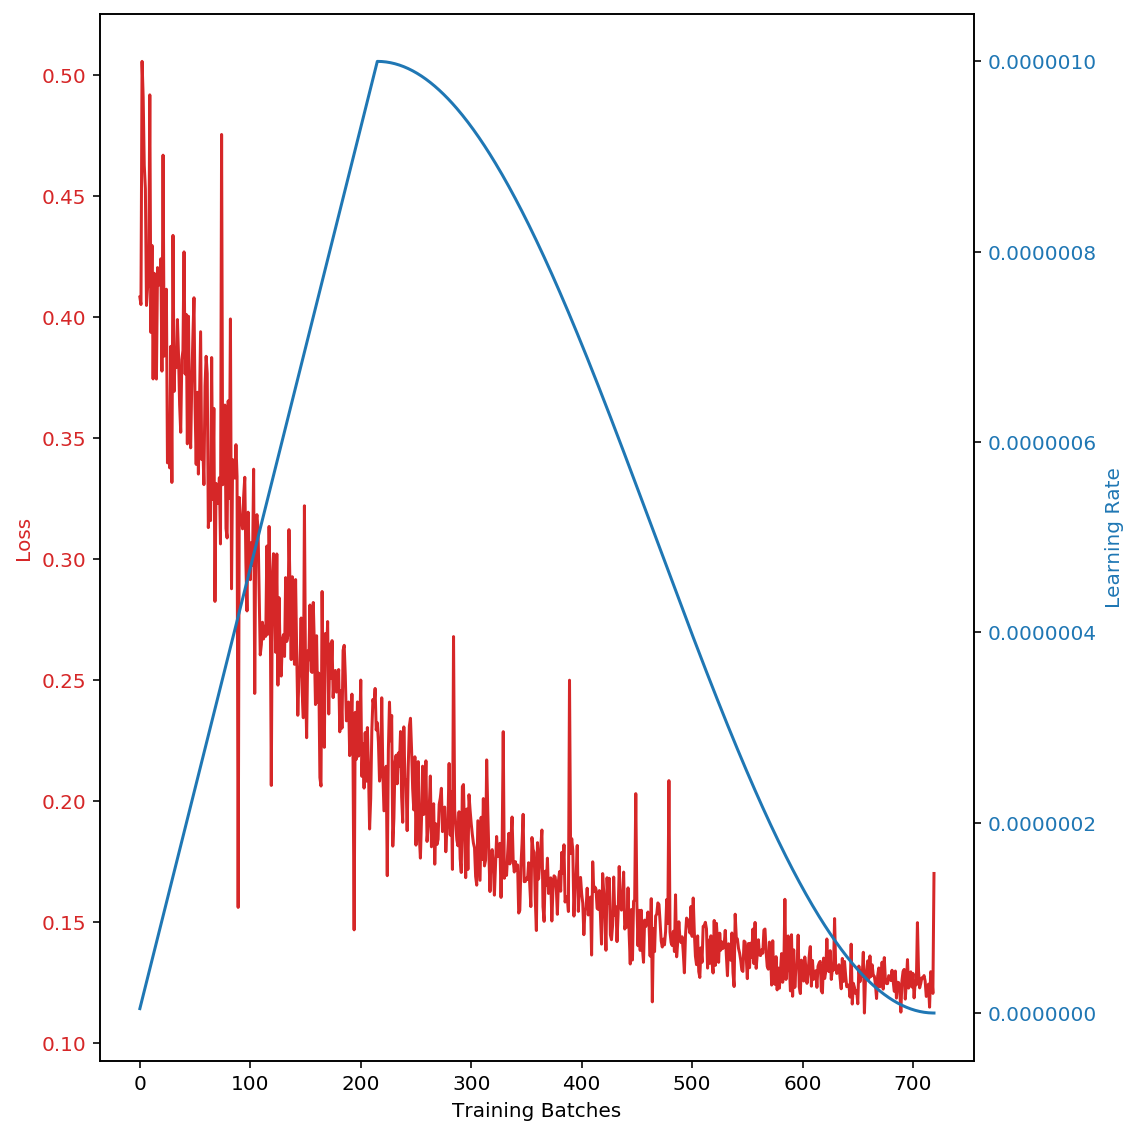

train   val
mean_or_std metric               
mean        map       0.686 0.640
            accuracy  0.735 0.714
            auc       0.774 0.750
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.734  0.913 0.813 4560.000     0.720  0.899 0.800 1140.000
pos     0.739  0.428 0.542 2640.000     0.694  0.395 0.504  660.000

In [9]:

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=6.0,
                              dropout=0.15,
                              word_masking_proba=0.175,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs



In [ ]:
# Either Regularization was too much or less
# Language pretraining was overdone so need to reduce LR there.


### DETR Style

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.529112 LR = 0.00000007


Exception for:  keyboard | ' ' ' ' | ['char_delete' 'one_third_cut' 'keyboard' 'text_rotate'] argument of type 'NoneType' is not iterable

Epoch =  2 Loss = 0.233975 LR = 0.00000014



Epoch =  3 Loss = 0.206990 LR = 0.00000021



Epoch =  4 Loss = 0.198637 LR = 0.00000028


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.526  0.526 0.518 0.537       1.000  1.000 1.000 1.000
1.000        0.527  0.527 0.518 0.537       1.000  1.000 1.000 1.000

,Probability,Predictions,Labels
436,0.528,1.000,0.000
1900,0.527,1.000,0.000
4201,0.528,1.000,0.000
3465,0.524,1.000,0.000
5136,0.521,1.000,0.000
6707,0.525,1.000,0.000
4285,0.527,1.000,1.000
6057,0.524,1.000,1.000
1672,0.526,1.000,1.000
5643,0.523,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.526  0.526 0.519 0.535       1.000  1.000 1.000 1.000
1.000        0.527  0.527 0.520 0.539       1.000  1.000 1.000 1.000

,Probability,Predictions,Labels
1208,0.524,1.000,0.000
1428,0.527,1.000,0.000
716,0.525,1.000,0.000
452,0.524,1.000,0.000
122,0.526,1.000,0.000
117,0.526,1.000,0.000
1039,0.527,1.000,1.000
1403,0.534,1.000,0.000
591,0.527,1.000,0.000
1772,0.526,1.000,0.000


Epoch =  4 Train = 0.605838 Val = 0.594082



Epoch =  5 Loss = 0.205126 LR = 0.00000035



Epoch =  6 Loss = 0.198211 LR = 0.00000042



Epoch =  7 Loss = 0.197796 LR = 0.00000049


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.415  0.415 0.406 0.430       0.000  0.000 0.000 0.000
1.000        0.417  0.416 0.406 0.431       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
6413,0.417,0.000,1.000
6060,0.414,0.000,0.000
3516,0.418,0.000,0.000
6858,0.410,0.000,0.000
646,0.413,0.000,1.000
2968,0.424,0.000,0.000
3564,0.415,0.000,0.000
2014,0.423,0.000,1.000
1206,0.415,0.000,0.000
5735,0.415,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.415  0.415 0.406 0.428       0.000  0.000 0.000 0.000
1.000        0.417  0.417 0.407 0.432       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1082,0.418,0.000,0.000
1029,0.408,0.000,0.000
1725,0.415,0.000,0.000
1473,0.416,0.000,1.000
553,0.420,0.000,0.000
223,0.413,0.000,0.000
884,0.414,0.000,0.000
941,0.420,0.000,0.000
1759,0.415,0.000,1.000
1755,0.411,0.000,1.000


Epoch =  7 Train = 0.626044 Val = 0.620737



Epoch =  8 Loss = 0.212310 LR = 0.00000056



Epoch =  9 Loss = 0.189995 LR = 0.00000062


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.498  0.498 0.494 0.506       0.137  0.000 0.000 1.000
1.000        0.499  0.499 0.494 0.507       0.265  0.000 0.000 1.000

,Probability,Predictions,Labels
5862,0.498,0.000,0.000
5122,0.497,0.000,1.000
1406,0.498,0.000,0.000
5083,0.500,1.000,1.000
3765,0.497,0.000,1.000
1565,0.500,0.000,0.000
5627,0.496,0.000,1.000
5716,0.498,0.000,1.000
5736,0.498,0.000,1.000
5733,0.497,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.498  0.498 0.493 0.505       0.164  0.000 0.000 1.000
1.000        0.499  0.499 0.494 0.507       0.267  0.000 0.000 1.000

,Probability,Predictions,Labels
1548,0.500,1.000,0.000
1331,0.496,0.000,1.000
1633,0.498,0.000,0.000
1037,0.504,1.000,0.000
36,0.495,0.000,1.000
442,0.502,1.000,1.000
71,0.498,0.000,1.000
1017,0.495,0.000,1.000
663,0.496,0.000,0.000
1394,0.500,1.000,0.000


Epoch =  9 Train = 0.624843 Val = 0.617760



Epoch =  10 Loss = 0.184634 LR = 0.00000069



Epoch =  11 Loss = 0.180349 LR = 0.00000076


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.457  0.457 0.445 0.476       0.000  0.000 0.000 0.000
1.000        0.460  0.460 0.446 0.477       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1900,0.465,0.000,1.000
2993,0.452,0.000,0.000
1904,0.457,0.000,0.000
6487,0.457,0.000,1.000
5029,0.459,0.000,0.000
6796,0.452,0.000,0.000
3516,0.460,0.000,0.000
3427,0.471,0.000,1.000
3158,0.453,0.000,0.000
3320,0.459,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.458  0.457 0.445 0.474       0.000  0.000 0.000 0.000
1.000        0.460  0.460 0.447 0.478       0.000  0.000 0.000 0.000

,Probability,Predictions,Labels
1765,0.465,0.000,1.000
476,0.464,0.000,1.000
728,0.456,0.000,0.000
1673,0.454,0.000,0.000
1351,0.451,0.000,1.000
9,0.460,0.000,0.000
402,0.447,0.000,1.000
111,0.451,0.000,0.000
835,0.461,0.000,0.000
338,0.464,0.000,0.000


Epoch =  11 Train = 0.636357 Val = 0.632468



Epoch =  12 Loss = 0.177390 LR = 0.00000083



Epoch =  13 Loss = 0.183543 LR = 0.00000090



Epoch =  14 Loss = 0.175410 LR = 0.00000097


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.480  0.477 0.444 0.512       0.215  0.000 0.000 1.000
1.000        0.492  0.498 0.445 0.513       0.468  0.000 0.000 1.000

,Probability,Predictions,Labels
3114,0.462,0.000,0.000
572,0.472,0.000,0.000
2374,0.512,1.000,1.000
4062,0.468,0.000,0.000
6468,0.485,0.000,0.000
6787,0.464,0.000,1.000
1501,0.479,0.000,0.000
6551,0.509,1.000,0.000
4546,0.467,0.000,0.000
5999,0.470,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.482  0.480 0.444 0.513       0.245  0.000 0.000 1.000
1.000        0.493  0.499 0.449 0.513       0.479  0.000 0.000 1.000

,Probability,Predictions,Labels
626,0.472,0.000,0.000
1570,0.478,0.000,0.000
1026,0.511,1.000,0.000
170,0.447,0.000,0.000
1439,0.467,0.000,1.000
342,0.494,0.000,0.000
1171,0.461,0.000,0.000
1260,0.510,1.000,0.000
867,0.474,0.000,0.000
1037,0.464,0.000,1.000


Epoch =  14 Train = 0.680606 Val = 0.666915



Epoch =  15 Loss = 0.173379 LR = 0.00000100



Epoch =  16 Loss = 0.170412 LR = 0.00000099



Epoch =  17 Loss = 0.167970 LR = 0.00000099


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.478  0.468 0.460 0.542       0.178  0.000 0.000 1.000
1.000        0.499  0.501 0.461 0.545       0.506  1.000 0.000 1.000

,Probability,Predictions,Labels
194,0.465,0.000,1.000
6708,0.538,1.000,1.000
5928,0.497,0.000,0.000
3145,0.520,1.000,0.000
555,0.521,1.000,1.000
4944,0.478,0.000,0.000
3072,0.513,1.000,0.000
62,0.467,0.000,0.000
3306,0.466,0.000,1.000
4272,0.470,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.479  0.469 0.461 0.541       0.189  0.000 0.000 1.000
1.000        0.499  0.503 0.461 0.542       0.518  1.000 0.000 1.000

,Probability,Predictions,Labels
858,0.525,1.000,0.000
1782,0.463,0.000,0.000
138,0.464,0.000,0.000
1526,0.501,1.000,0.000
194,0.465,0.000,0.000
1044,0.520,1.000,0.000
89,0.522,1.000,1.000
282,0.467,0.000,0.000
450,0.530,1.000,1.000
115,0.469,0.000,1.000


Epoch =  17 Train = 0.737272 Val = 0.716143



Epoch =  18 Loss = 0.162094 LR = 0.00000097



Epoch =  19 Loss = 0.170884 LR = 0.00000095


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.481  0.478 0.466 0.505       0.031  0.000 0.000 1.000
1.000        0.490  0.494 0.466 0.505       0.171  0.000 0.000 1.000

,Probability,Predictions,Labels
6251,0.470,0.000,0.000
5759,0.469,0.000,0.000
2815,0.495,0.000,1.000
6383,0.477,0.000,0.000
6635,0.495,0.000,1.000
1363,0.477,0.000,1.000
5430,0.493,0.000,1.000
3618,0.492,0.000,1.000
3378,0.473,0.000,0.000
3011,0.469,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.482  0.479 0.466 0.504       0.040  0.000 0.000 1.000
1.000        0.490  0.494 0.467 0.505       0.188  0.000 0.000 1.000

,Probability,Predictions,Labels
717,0.485,0.000,0.000
176,0.497,0.000,1.000
1539,0.494,0.000,1.000
1723,0.502,1.000,1.000
190,0.501,1.000,1.000
1483,0.498,0.000,1.000
141,0.480,0.000,0.000
1742,0.487,0.000,0.000
97,0.493,0.000,1.000
1619,0.475,0.000,0.000


Epoch =  19 Train = 0.737997 Val = 0.714369



Epoch =  20 Loss = 0.171040 LR = 0.00000093



Epoch =  21 Loss = 0.166163 LR = 0.00000091



Epoch =  22 Loss = 0.164707 LR = 0.00000088



Epoch =  23 Loss = 0.163739 LR = 0.00000085


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.470  0.465 0.462 0.548       0.061  0.000 0.000 1.000
1.000        0.486  0.470 0.462 0.553       0.285  0.000 0.000 1.000

,Probability,Predictions,Labels
2562,0.465,0.000,0.000
4142,0.465,0.000,0.000
1283,0.468,0.000,1.000
6862,0.464,0.000,0.000
5377,0.463,0.000,0.000
1624,0.525,1.000,1.000
1601,0.466,0.000,1.000
5120,0.468,0.000,0.000
2460,0.463,0.000,0.000
6271,0.469,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.471  0.465 0.462 0.546       0.071  0.000 0.000 1.000
1.000        0.486  0.470 0.462 0.552       0.295  0.000 0.000 1.000

,Probability,Predictions,Labels
1355,0.466,0.000,0.000
1605,0.534,1.000,0.000
762,0.468,0.000,0.000
912,0.465,0.000,0.000
496,0.472,0.000,0.000
1537,0.464,0.000,0.000
108,0.467,0.000,0.000
96,0.512,1.000,1.000
1200,0.466,0.000,0.000
1620,0.478,0.000,0.000


Epoch =  23 Train = 0.750888 Val = 0.714731



Epoch =  24 Loss = 0.163177 LR = 0.00000081



Epoch =  25 Loss = 0.161844 LR = 0.00000077



Epoch =  26 Loss = 0.161801 LR = 0.00000073



Epoch =  27 Loss = 0.160937 LR = 0.00000069


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.468  0.458 0.450 0.556       0.110  0.000 0.000 1.000
1.000        0.495  0.486 0.450 0.557       0.429  0.000 0.000 1.000

,Probability,Predictions,Labels
5054,0.515,1.000,1.000
7105,0.534,1.000,1.000
7110,0.496,0.000,0.000
3110,0.453,0.000,0.000
6450,0.545,1.000,1.000
2616,0.454,0.000,0.000
6022,0.464,0.000,1.000
2349,0.460,0.000,1.000
2145,0.465,0.000,0.000
4640,0.476,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.470  0.459 0.450 0.556       0.135  0.000 0.000 1.000
1.000        0.495  0.485 0.451 0.557       0.421  0.000 0.000 1.000

,Probability,Predictions,Labels
1521,0.476,0.000,1.000
1227,0.505,1.000,0.000
379,0.452,0.000,0.000
64,0.514,1.000,1.000
1392,0.453,0.000,0.000
178,0.452,0.000,0.000
701,0.486,0.000,1.000
1516,0.455,0.000,0.000
1690,0.455,0.000,0.000
1241,0.530,1.000,0.000


Epoch =  27 Train = 0.755219 Val = 0.715837



Epoch =  28 Loss = 0.162766 LR = 0.00000065



Epoch =  29 Loss = 0.160942 LR = 0.00000060



Epoch =  30 Loss = 0.161022 LR = 0.00000056



Epoch =  31 Loss = 0.163285 LR = 0.00000051


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.482  0.478 0.451 0.550       0.174  0.000 0.000 1.000
1.000        0.506  0.507 0.452 0.553       0.551  1.000 0.000 1.000

,Probability,Predictions,Labels
3502,0.472,0.000,0.000
296,0.463,0.000,0.000
5446,0.528,1.000,0.000
5296,0.542,1.000,0.000
5833,0.535,1.000,0.000
3604,0.507,1.000,1.000
6812,0.481,0.000,0.000
2239,0.537,1.000,1.000
2597,0.481,0.000,0.000
1229,0.470,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.480 0.451 0.551       0.203  0.000 0.000 1.000
1.000        0.506  0.506 0.453 0.552       0.542  1.000 0.000 1.000

,Probability,Predictions,Labels
1180,0.491,0.000,0.000
1515,0.456,0.000,1.000
471,0.514,1.000,0.000
906,0.492,0.000,1.000
424,0.470,0.000,0.000
1585,0.500,0.000,0.000
28,0.541,1.000,1.000
1581,0.547,1.000,1.000
1234,0.531,1.000,1.000
737,0.475,0.000,0.000


Epoch =  31 Train = 0.761365 Val = 0.723143



Epoch =  32 Loss = 0.160758 LR = 0.00000046



Epoch =  33 Loss = 0.157157 LR = 0.00000042



Epoch =  34 Loss = 0.162217 LR = 0.00000037


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.468  0.468 0.428 0.560       0.113  0.000 0.000 1.000
1.000        0.499  0.493 0.428 0.563       0.447  0.000 0.000 1.000

,Probability,Predictions,Labels
6502,0.500,0.000,0.000
1663,0.543,1.000,1.000
6071,0.439,0.000,1.000
51,0.457,0.000,0.000
6714,0.465,0.000,1.000
852,0.431,0.000,0.000
3553,0.511,1.000,0.000
3919,0.488,0.000,0.000
1966,0.486,0.000,0.000
6162,0.535,1.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.470  0.472 0.428 0.561       0.138  0.000 0.000 1.000
1.000        0.498  0.493 0.428 0.562       0.438  0.000 0.000 1.000

,Probability,Predictions,Labels
301,0.457,0.000,0.000
290,0.449,0.000,0.000
1428,0.486,0.000,1.000
1249,0.554,1.000,1.000
666,0.443,0.000,0.000
724,0.478,0.000,1.000
1609,0.482,0.000,0.000
1499,0.518,1.000,0.000
1217,0.541,1.000,1.000
1115,0.446,0.000,0.000


Epoch =  34 Train = 0.766584 Val = 0.725936



Epoch =  35 Loss = 0.158309 LR = 0.00000033



Epoch =  36 Loss = 0.156998 LR = 0.00000028



Epoch =  37 Loss = 0.160969 LR = 0.00000024


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.481  0.475 0.452 0.558       0.213  0.000 0.000 1.000
1.000        0.511  0.514 0.452 0.560       0.613  1.000 0.000 1.000

,Probability,Predictions,Labels
4151,0.514,1.000,1.000
5554,0.533,1.000,1.000
5280,0.479,0.000,0.000
1397,0.479,0.000,1.000
1553,0.500,0.000,1.000
5211,0.461,0.000,0.000
1535,0.514,1.000,0.000
2055,0.459,0.000,0.000
1253,0.548,1.000,1.000
6534,0.486,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.478 0.452 0.559       0.246  0.000 0.000 1.000
1.000        0.510  0.514 0.453 0.559       0.597  1.000 0.000 1.000

,Probability,Predictions,Labels
1698,0.457,0.000,0.000
5,0.539,1.000,1.000
185,0.541,1.000,1.000
981,0.467,0.000,0.000
585,0.483,0.000,0.000
1029,0.465,0.000,0.000
1236,0.468,0.000,1.000
41,0.459,0.000,0.000
1568,0.460,0.000,0.000
215,0.495,0.000,0.000


Epoch =  37 Train = 0.769649 Val = 0.727301



Epoch =  38 Loss = 0.159147 LR = 0.00000020



Epoch =  39 Loss = 0.158496 LR = 0.00000017



Epoch =  40 Loss = 0.160286 LR = 0.00000013



Epoch =  41 Loss = 0.159812 LR = 0.00000010


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.478  0.473 0.437 0.571       0.212  0.000 0.000 1.000
1.000        0.514  0.516 0.437 0.573       0.613  1.000 0.000 1.000

,Probability,Predictions,Labels
5005,0.470,0.000,0.000
2726,0.470,0.000,0.000
2704,0.511,1.000,1.000
4693,0.449,0.000,0.000
6558,0.482,0.000,1.000
2785,0.485,0.000,0.000
4155,0.491,0.000,0.000
7112,0.453,0.000,1.000
542,0.460,0.000,0.000
5914,0.459,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.481  0.479 0.437 0.571       0.234  0.000 0.000 1.000
1.000        0.512  0.515 0.438 0.572       0.595  1.000 0.000 1.000

,Probability,Predictions,Labels
329,0.568,1.000,1.000
1245,0.568,1.000,1.000
252,0.456,0.000,0.000
1677,0.449,0.000,0.000
1523,0.485,0.000,0.000
1154,0.464,0.000,0.000
253,0.493,0.000,1.000
1207,0.562,1.000,1.000
172,0.475,0.000,0.000
533,0.451,0.000,0.000


Epoch =  41 Train = 0.771929 Val = 0.727091



Epoch =  42 Loss = 0.158031 LR = 0.00000008


Exception for:  keyboard | '' '' | ['half_cut' 'sentence_shuffle' 'word_cutout' 'keyboard' 'stopword_insert'] argument of type 'NoneType' is not iterable

Epoch =  43 Loss = 0.155354 LR = 0.00000005



Epoch =  44 Loss = 0.156557 LR = 0.00000003


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.476  0.465 0.430 0.584       0.229  0.000 0.000 1.000
1.000        0.520  0.525 0.431 0.585       0.632  1.000 0.000 1.000

,Probability,Predictions,Labels
6448,0.490,0.000,1.000
3000,0.540,1.000,1.000
4915,0.473,0.000,0.000
53,0.582,1.000,1.000
3092,0.485,0.000,1.000
6474,0.583,1.000,1.000
5065,0.481,0.000,0.000
2628,0.503,1.000,1.000
367,0.444,0.000,1.000
611,0.486,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.480  0.470 0.430 0.585       0.255  0.000 0.000 1.000
1.000        0.517  0.522 0.431 0.585       0.611  1.000 0.000 1.000

,Probability,Predictions,Labels
1369,0.447,0.000,0.000
1493,0.553,1.000,0.000
330,0.510,1.000,0.000
1450,0.471,0.000,0.000
953,0.460,0.000,0.000
333,0.577,1.000,1.000
936,0.529,1.000,1.000
894,0.525,1.000,1.000
1442,0.438,0.000,0.000
1192,0.497,0.000,0.000


Epoch =  44 Train = 0.772742 Val = 0.726326



Epoch =  45 Loss = 0.159630 LR = 0.00000002



Epoch =  46 Loss = 0.157575 LR = 0.00000001



Epoch =  47 Loss = 0.158281 LR = 0.00000000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.480  0.472 0.431 0.586       0.258  0.000 0.000 1.000
1.000        0.524  0.529 0.432 0.587       0.659  1.000 0.000 1.000

,Probability,Predictions,Labels
5562,0.522,1.000,0.000
6479,0.486,0.000,1.000
2846,0.527,1.000,1.000
4907,0.513,1.000,0.000
7,0.495,0.000,1.000
3935,0.530,1.000,0.000
3540,0.456,0.000,0.000
2287,0.472,0.000,0.000
3606,0.473,0.000,0.000
130,0.440,0.000,0.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.478 0.431 0.586       0.289  0.000 0.000 1.000
1.000        0.522  0.527 0.433 0.587       0.636  1.000 0.000 1.000

,Probability,Predictions,Labels
1638,0.478,0.000,0.000
423,0.495,0.000,1.000
710,0.454,0.000,0.000
236,0.543,1.000,1.000
191,0.493,0.000,0.000
1219,0.499,0.000,0.000
962,0.442,0.000,0.000
1395,0.486,0.000,0.000
1335,0.473,0.000,0.000
1394,0.483,0.000,0.000


Epoch =  47 Train = 0.773144 Val = 0.726743



Epoch =  48 Loss = 0.154522 LR = 0.00000000



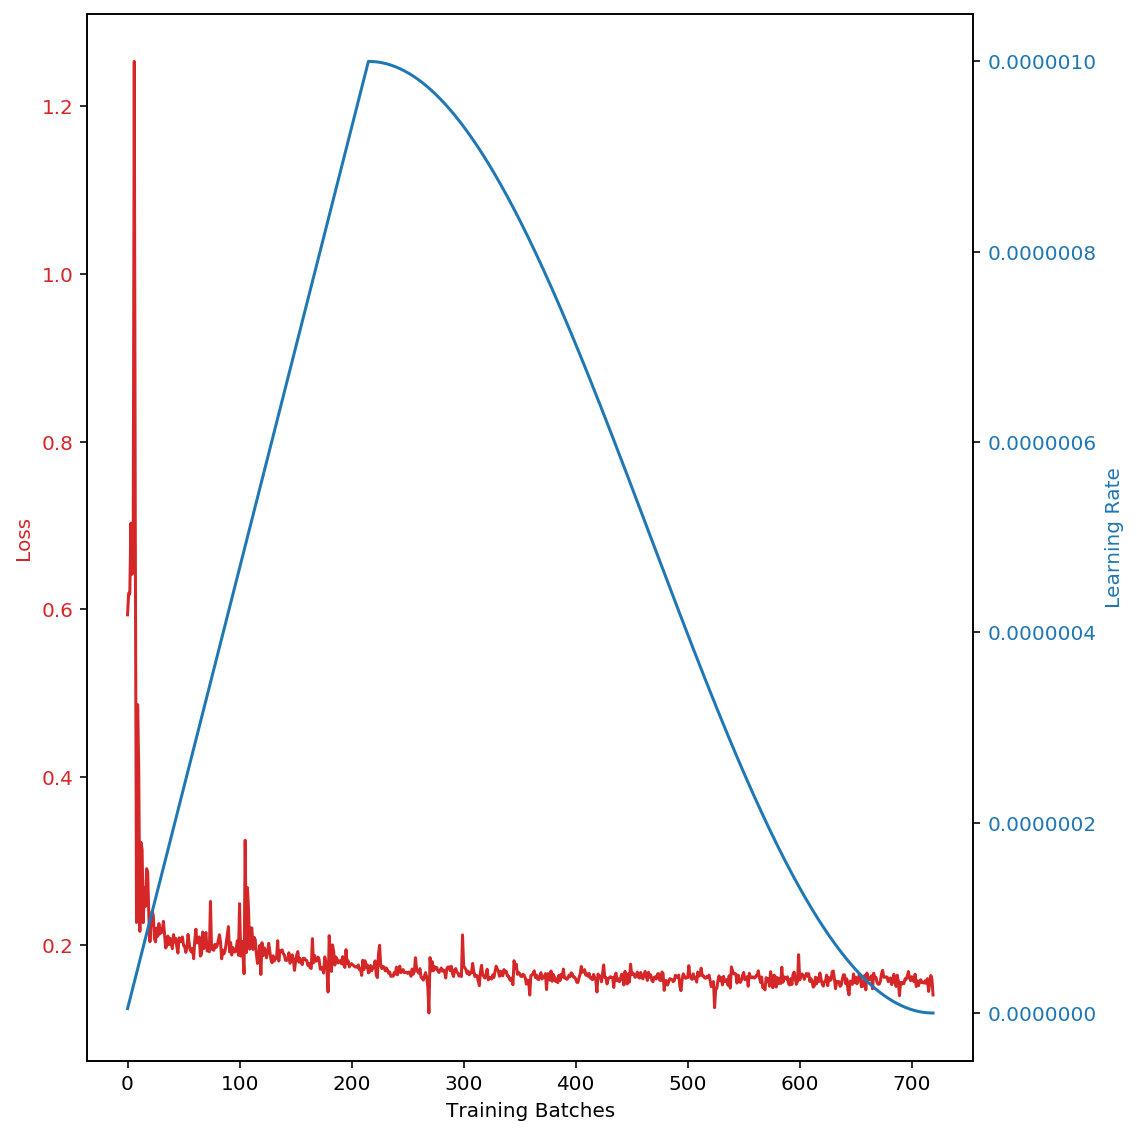

Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.484  0.478 0.431 0.586       0.289  0.000 0.000 1.000
1.000        0.521  0.527 0.433 0.587       0.636  1.000 0.000 1.000

,Probability,Predictions,Labels
431,0.579,1.000,0.000
1220,0.470,0.000,0.000
1205,0.443,0.000,0.000
697,0.463,0.000,0.000
934,0.459,0.000,1.000
1231,0.436,0.000,0.000
501,0.443,0.000,0.000
1188,0.502,1.000,1.000
1300,0.563,1.000,0.000
554,0.452,0.000,1.000


Probability                    Predictions                   
              mean median   min   max        mean median   min   max
Labels                                                              
0.000        0.480  0.472 0.431 0.586       0.257  0.000 0.000 1.000
1.000        0.524  0.529 0.432 0.587       0.659  1.000 0.000 1.000

,Probability,Predictions,Labels
2349,0.482,0.000,1.000
6532,0.448,0.000,0.000
2011,0.487,0.000,1.000
7189,0.562,1.000,1.000
2411,0.453,0.000,0.000
4437,0.519,1.000,0.000
6179,0.440,0.000,0.000
1396,0.486,0.000,1.000
4780,0.439,0.000,1.000
6313,0.486,0.000,1.000


train   val
mean_or_std metric               
mean        map       0.665 0.625
            accuracy  0.712 0.683
            auc       0.773 0.727
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.790  0.743 0.766 4560.000     0.771  0.711 0.740 1140.000
pos     0.597  0.659 0.627 2640.000     0.560  0.636 0.596  660.000

In [11]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.0, # 4.75
                              dropout=0.05,
                              word_masking_proba=0.15,
                              internal_dims=512,
                              final_layer_builder=fb_detr_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              loss="focal",
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.759	0.752 (0.717	0.716)
# 0.0.760	0.745 (725	0.721) # 15m 41s


# Predict

## Normal Head

In [9]:
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.0,
                              dropout=0.0,
                              word_masking_proba=0.15,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


In [10]:
epochs = 4
batch_size = 256

submission, text_model = train_and_predict(model_fn, data, batch_size, epochs, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched,
                                           sampling_policy="without_replacement",
                                           validation_epochs=[4],
                                          )
submission.to_csv("submission.csv",index=False)
submission.sample(5)


Autocast =  True Epochs =  8 Divisor = 2 Examples = 4500 Batch Size =  256
Training Samples =  9000 Weighted Sampling =  True Num Batches =  18 Accumulation steps =  1


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.





Traceback (most recent call last):
  File "/home/ahemf/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-57dc87ae7f26>", line 8, in <module>
    validation_epochs=[4],
  File "/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/training/fb_competition.py", line 44, in train_and_predict
    sampling_policy=sampling_policy, class_weights=class_weights)
  File "/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/training/generic.py", line 205, in train
    _, _, _, loss = model(batch)
  File "/home/ahemf/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 722, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/models/text_models/Fasttext1DCNN.py", line 81, in forward
    vectors = self.featurizer(v

KeyboardInterrupt: 

## DETR Style head

Autocast =  True Epochs =  8 Divisor = 2 Examples = 4500 Batch Size =  256
Training Samples =  9000 Weighted Sampling =  True Num Batches =  18 Accumulation steps =  1



Epoch =  1 Loss = 0.174021 LR = 0.00000042



Epoch =  2 Loss = 0.130238 LR = 0.00000084


,Probability,Predictions,Labels
0,0.427,0.000,0.000
1,0.428,0.000,0.000
2,0.428,0.000,0.000
3,0.428,0.000,0.000
4,0.427,0.000,1.000
5,0.428,0.000,0.000
6,0.428,0.000,0.000
7,0.428,0.000,1.000
8,0.429,0.000,1.000
9,0.428,0.000,1.000


Epoch =  2 Train = 0.617134 Val = 0.000000



Epoch =  3 Loss = 0.115956 LR = 0.00000097



Epoch =  4 Loss = 0.106240 LR = 0.00000081



Epoch =  5 Loss = 0.101473 LR = 0.00000055


,Probability,Predictions,Labels
0,0.481,0.000,0.000
1,0.485,0.000,1.000
2,0.481,0.000,0.000
3,0.479,0.000,0.000
4,0.480,0.000,0.000
5,0.481,0.000,0.000
6,0.480,0.000,1.000
7,0.481,0.000,1.000
8,0.479,0.000,1.000
9,0.480,0.000,1.000


Epoch =  5 Train = 0.667988 Val = 0.000000



Epoch =  6 Loss = 0.099925 LR = 0.00000028



Epoch =  7 Loss = 0.098479 LR = 0.00000008


,Probability,Predictions,Labels
0,0.491,0.000,0.000
1,0.493,0.000,0.000
2,0.491,0.000,0.000
3,0.490,0.000,1.000
4,0.491,0.000,0.000
5,0.491,0.000,0.000
6,0.491,0.000,0.000
7,0.493,0.000,1.000
8,0.490,0.000,0.000
9,0.491,0.000,0.000


Epoch =  7 Train = 0.683348 Val = 0.000000



Epoch =  8 Loss = 0.097772 LR = 0.00000000



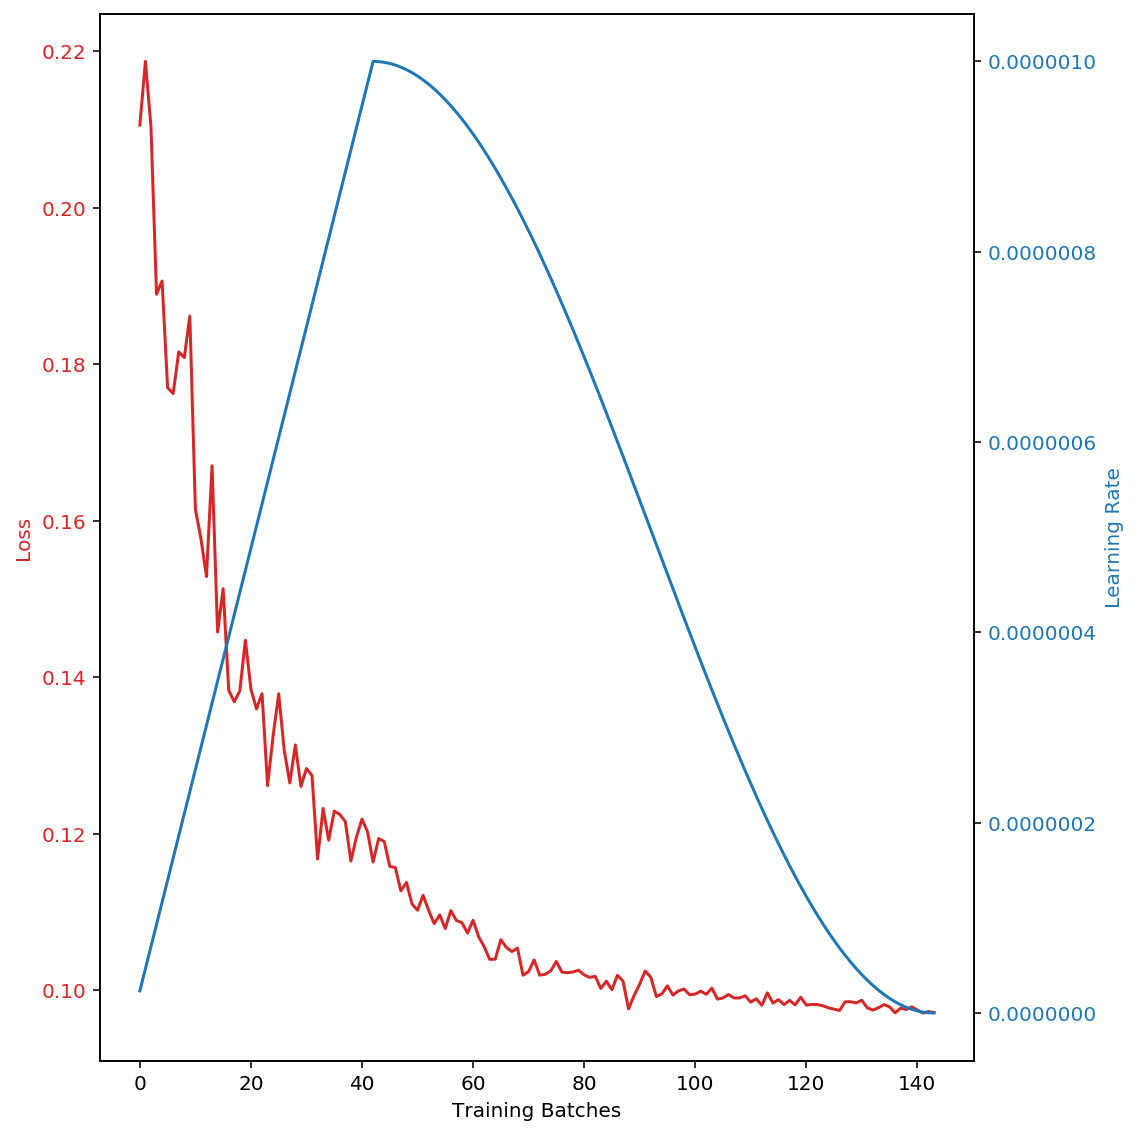

,id,proba,label
86,95723,0.490,0
288,81527,0.493,0
954,62085,0.495,0
367,84321,0.490,0
155,6931,0.491,0
876,41370,0.490,0
826,13792,0.491,0
939,31892,0.490,0
149,45269,0.491,0
223,51482,0.490,0


In [10]:
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}

model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.0, # 4.75
                              dropout=0.1,
                              word_masking_proba=0.0,
                              internal_dims=512,
                              final_layer_builder=fb_detr_loss_builder,
                              n_layers=2,
                              n_encoders=3,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=96,
                              featurizer="transformer",
                              model='./model-nsp',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

epochs = 4
batch_size = 256

submission, text_model = train_and_predict(model_fn, data, batch_size, epochs,
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched, validation_epochs=[2, 5, 7],
                                           sampling_policy="without_replacement")
submission.to_csv("submission.csv",index=False)
submission.sample(10)



In [ ]:
# What train-auc does we achieve if all examples have same score.
# What train-auc does we achieve if all examples have random score.

In [18]:
submission.sample(10)

,id,proba,label
851,27180,0.491,0
358,7612,0.492,0
713,19672,0.492,0
879,85764,0.491,0
301,39247,0.491,0
307,4239,0.490,0
246,47863,0.491,0
393,26910,0.490,0
667,8567,0.491,0
506,82547,0.491,0
